<a href="https://colab.research.google.com/github/yanirasilva-star/GRUPO-3-ICD/blob/main/TG4_ICD_FINAL_G3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introducción A Ciencia De Datos Y Machine Learning Con Python**

**Integrantes:**



*   Arizaba Garcia Topacio

*   Silva Ruiz Yanira
*   Vega castro Angie


*   Vasquez Milian Andy


**Profesor:** Luis Jose Zapata Bobadilla

**Universidad de Piura**


# **Pregunta**: *¿Cuál es la influencia de la tasa de interés de referencia en la dinámica de la inflación en el corto plazo en el Perú?*

### *Modelado Predictivo de la Inflación Subyacente*

El objetivo de este trabajo es evaluar la capacidad predictiva de distintos modelos estadísticos y de machine learning para estimar la inflación subyacente interanual en el Perú, utilizando variables macroeconómicas y de política monetaria. El análisis tiene un enfoque predictivo, no inferencial.

### **1. Definición del periodo y variables**

 **PERIÓDO**
* Periodo inicial: **Enero del 2010**
* Periodo final: **Agosto del 2025**

**VARIABLES**
1. PN01278PM: Inflación Subyacente interanual
2. PD12912AM: Expectativas de inflación a 12 meses
3. PD04722MM: Tasa de interés de referencia (TIR)
4. PN07819NM: Tasa de interés interbancaria promedio
5.  PN06522TM: repo de valores saldo
6. PN06534TM: depósitos públicos saldo
7. PN06502OM: CD BCRP - Total - Saldo
8. PN06503OM: CD BCRP - Tasa de ínteres - Saldo
9. PN07150NM: Depositos overnight BCRP (promedio diario) - Empresas Bancarias (miles S/)
10. PD04724MM: Tasa de los Depósitos Overnight en MN



# **TG 1**
 ## **1.1.carga de Librerías**

In [1]:
# Primero, importamos las librerías que necesitaremos
import requests  # La librería estándar en Python para hacer peticiones a la web
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import os                   # Módulo para interactuar con el sistema operativo
import warnings
import sklearn, statsmodels
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV          # Ridge y Ridge con validación cruzada
from sklearn.pipeline import Pipeline                    # Para encadenar pasos (escalado + modelo)
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


## **1.2 Carga de series y definicion de parámetros**

In [2]:
# 1. Definimos los parámetros de nuestra consulta
codigos = 'PD04722MM-PN07819NM-PN06522TM-PN06534TM-PN06502OM-PN06503OM-PN07150NM-PD04724MM-PN01279PM-PD12912AM'
formato = 'json' # Pedimos los datos en formato JSON
periodo_inicial = '2013-01'
periodo_final = '2025-08'

# 2. Construimos la URL completa
url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codigos}/{formato}/{periodo_inicial}/{periodo_final}"

# 3. Hacemos la petición GET a la web del BCRP
response = requests.get(url)

# 4. Verificamos que la petición fue exitosa (un código 200 significa que todo salió bien)
if response.status_code == 200:
    print("¡Conexión exitosa con el API del BCRP!")
    # Convertimos la respuesta a un formato de diccionario de Python
    data = response.json()
else:
    print(f"Error al conectar con el API. Código de estado: {response.status_code}")
    data = None

¡Conexión exitosa con el API del BCRP!


 ## **1.3.Inspección de la estructura de datos sin procesar:**

Antes de convertir los datos a un formato estructurado como un DataFrame de Pandas, inspeccionamos los datos sin procesar recibidos de la API de BCRP para comprender su organización. Esto se realizó imprimiendo las dos primeras y la última entrada de la  lista "periods"  dentro del  objeto "data"  . Esto nos permitió ver:

*    El formato de la información de fecha (que  más tarde se convertiría en la  columna **'Fecha'**  en nuestro DataFrame).
*  Cómo se almacenan   los valores de cada variable (que más tarde llenarían columnas como  **'Tasa\_Ref (%)'** ,  **'IPC (%)'** , etc.) en una lista para cada período.
*    El orden en que aparecen estos valores de variable  en la lista para cada período, lo cual fue crucial para  extraer y etiquetar correctamente los datos en las columnas apropiadas del DataFrame.

Este paso confirmó que los datos están estructurados como  una lista de períodos, donde cada período contiene una fecha y una lista de valores de variables correspondientes en  un orden consistente, preparándonos para crear nuestro DataFrame estructurado.

In [3]:
# Miremos los datos de los primeros dos periodos para entender la estructura
# [tasa de interés de ref, tasa de depósitos overnight, CDBCR total saldo, CDBCR saldo tasa de interés, repos de valores, depósitos públicos, depósitos overnight BCR,  tasa de interés interbancaria, IPC]
if data:
    print(data['periods'][0])
    print(data['periods'][1])
    print(data['periods'][-1])

{'name': 'Ene.2013', 'values': ['2.59166666666667', '4.053', '36762.4', '0', '0', '3.45', '4.25', '4.1518', '3.3380626594732', '367807']}
{'name': 'Feb.2013', 'values': ['2.575', '4.03', '36200.2', '0', '0', '3.45', '4.25', '4.2008', '3.22198998409693', '47590']}
{'name': 'Ago.2025', 'values': ['2.18333333333333', '4.2065169497112', '43991.9', '4024.9', '7306.825629', '2.5', '4.5', '4.5079', '2.09918594926549', '78929.5483870968']}


## **1.4. Estructuración de los datos en un DataFrame**


Este bloque de código se centra en convertir los datos sin procesar , en formato de lista de diccionarios, en  un DataFrame estructurado de Pandas.

Así es como funciona:

* **Inicialización de listas:**  Se crean listas vacías para cada variable (p. ej.,  `fechas` ,  `tir` ,  `ipc` ) para almacenar temporalmente los datos extraídos.  
*  **Iteración por períodos:**  El código recorre cada  `period`  en la  lista `data['periods']`  obtenida de la API de BCRP.  
*  **Extracción de datos:**  Dentro del bucle:  
    *  Se extrae    la fecha ( `period['name']` ) y se agrega a la  lista `fechas` .
    *  Se extrae   la lista de valores de todas las variables ( `period['values']` ).
    *    Para cada variable, se accede al valor correspondiente desde la  lista `valores`  usando su índice (según el orden de los códigos  en la llamada a la API).
    *    El valor extraído se convierte a un  `float`  si es un número válido. Si el valor es 'nd' (que indica no disponible), se reemplaza con  `np.nan`  (no es un número) para representar los datos faltantes en el DataFrame .
    *    Estos valores procesados ​​se añaden a sus respectivas listas.
*  **Creación del DataFrame:**  Después de procesar todos los períodos,   se crea un diccionario `datos_para_df` . Las claves de este diccionario son los nombres de columna deseados para el DataFrame (por ejemplo, 'Fech a', 'Tasa\_Ref (%)'), y los valores son las listas  que contienen los datos extraídos y procesados ​​para cada variable.  
*  **Relleno del DataFrame:** Finalmente,  se crea   un DataFrame de pandas  `df_bcrp` a partir del diccionario `datos_para_df`  . La  línea `display(df_bcrp.head())`  muestra las primeras filas del DataFrame recién creado, lo que permite una rápida verificación de  la estructura y los datos.

Este proceso transforma eficazmente los datos sin procesar de la API en un formato tabular limpio, listo para su posterior análisis y visualización en los  pasos posteriores.

In [4]:
if data:
    # Creamos listas vacías
    fechas = []
    inflación_subyacente_var12m = []
    cdbcr_tir = []
    cdbcr_total = []
    depositos_publicos = []
    repos_valores = []
    tover = []
    tir = []
    interbancaria = []
    expectativas_inflacion = []
    depositos_overnight = []


      # Empezamos ipc_variacion con NaN para el primer mes

    # Iteramos sobre los periodos en los datos del BCRP
    for periodo in data['periods']:
        fechas.append(periodo['name'])

        # Los valores vienen en el mismo orden en que pusiste los códigos en la URL:
        valores = periodo['values']

        # Inflación subyacente
        inflación_subyacente_var12m.append(float(valores[0]) if valores[0] != 'n.d.' else np.nan)
        # CDBCR saldo tasa de interés
        cdbcr_tir.append(float(valores[1]) if valores[1] != 'n.d.' else np.nan)
        # CDBCR total saldo
        cdbcr_total.append(float(valores[2]) if valores[2] != 'n.d.' else np.nan)
        # Depósitos públicos (saldo)
        depositos_publicos.append(float(valores[3]) if valores[3] != 'n.d.' else np.nan)
        # Repos (saldo)
        repos_valores.append(float(valores[4]) if valores[4] != 'n.d.' else np.nan)
        # Depósitos overnight
        tover.append(float(valores[5]) if valores[5] != 'n.d.' else np.nan)
        # Tasa de interés de referencia
        tir.append(float(valores[6]) if valores[6] != 'n.d.' else np.nan)
        # Tasa interbancaria promedio
        interbancaria.append(float(valores[7]) if valores[7] != 'n.d.' else np.nan)
        # Expectativas de inflacion
        expectativas_inflacion.append(float(valores[8]) if valores[8] != 'n.d.' else np.nan)
        # Depósitos overnight BCR
        depositos_overnight.append(float(valores[9]) if valores[9] != 'n.d.' else np.nan)


    # Construimos el DataFrame
    datos_para_df = {
        'Fecha': fechas,
        'Inflación_Mensual_Subyacente_12m (%)': inflación_subyacente_var12m,
        'CDBCR_Saldo_TIR (%)': cdbcr_tir,
        'CDBCR_Total_Saldo (S/ millones)': cdbcr_total,
        'Depositos_Publicos_Saldo (S/ millones)': depositos_publicos,
        'Repos_Valores (S/ millones)': repos_valores,
        'Tasa_Depositos_Overnight (%)': tover,
        'Tasa_Ref (%)': tir,
        'Tasa_Interbancaria (%)': interbancaria,
        'Expectativas_Inflacion_12m (%)': expectativas_inflacion,
        'Depositos_Overnight_BCR (S/ miles)': depositos_overnight,

    }

    df_bcrp = pd.DataFrame(datos_para_df)

    print("DataFrame creado exitosamente:")
    display(df_bcrp.head())
else:
    print("No se pudieron cargar los datos para crear el DataFrame.")


DataFrame creado exitosamente:


,Fecha,Inflación_Mensual_Subyacente_12m (%),CDBCR_Saldo_TIR (%),CDBCR_Total_Saldo (S/ millones),Depositos_Publicos_Saldo (S/ millones),Repos_Valores (S/ millones),Tasa_Depositos_Overnight (%),Tasa_Ref (%),Tasa_Interbancaria (%),Expectativas_Inflacion_12m (%),Depositos_Overnight_BCR (S/ miles)
0,Ene.2013,2.591667,4.053,36762.4,0.0,0.0,3.45,4.25,4.1518,3.338063,367807.0
1,Feb.2013,2.575000,4.030,36200.2,0.0,0.0,3.45,4.25,4.2008,3.221990,47590.0
2,Mar.2013,2.562500,3.960,36034.7,0.0,0.0,3.45,4.25,4.2404,3.477736,201773.0
3,Abr.2013,2.483333,3.970,37175.0,0.0,0.0,3.45,4.25,4.2005,3.404137,122430.0
4,May.2013,2.479167,3.860,33493.0,0.0,0.0,3.45,4.25,4.2542,3.318773,23520.0


## **1.5 Limpieza de data y Descripcion:**
Este bloque de código se encarga de la limpieza de datos, específicamente eliminando filas que contienen valores faltantes (NaN) en cualquier columna del DataFrame `df_bcrp`.


* `df_bcrp.dropna(inplace=True)`Esta línea elimina cualquier fila del DataFrame df_bcrpque contenga al menos un valor faltante ( NaN).
* `El inplace=True`Modifica el DataFrame directamente sin crear uno nuevo.
`df_bcrp.info()`:Esta línea muestra luego un resumen conciso del DataFrame modificado.
El resultado `df_bcrp.info()`después de la ejecución `dropna()`muestra la estructura del DataFrame, incluyendo el número de entradas (filas) y el recuento de valores no nulos en cada columna. Si el número de entradas es menor que el original (que era 188 antes de este paso, como se muestra en el resultado del paso anterior `df_bcrp.info()`), significa que se eliminaron correctamente algunas filas con valores faltantes.


In [5]:
# Eliminar las filas con valores faltantes en cualquier columna
df_bcrp.dropna(inplace=True)

# Verificar nuevamente el estado del DataFrame
df_bcrp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Fecha                                   152 non-null    object 
 1   Inflación_Mensual_Subyacente_12m (%)    152 non-null    float64
 2   CDBCR_Saldo_TIR (%)                     152 non-null    float64
 3   CDBCR_Total_Saldo (S/ millones)         152 non-null    float64
 4   Depositos_Publicos_Saldo (S/ millones)  152 non-null    float64
 5   Repos_Valores (S/ millones)             152 non-null    float64
 6   Tasa_Depositos_Overnight (%)            152 non-null    float64
 7   Tasa_Ref (%)                            152 non-null    float64
 8   Tasa_Interbancaria (%)                  152 non-null    float64
 9   Expectativas_Inflacion_12m (%)          152 non-null    float64
 10  Depositos_Overnight_BCR (S/ miles)      152 non-null    float6

In [6]:
df_bcrp.describe()

,Inflación_Mensual_Subyacente_12m (%),CDBCR_Saldo_TIR (%),CDBCR_Total_Saldo (S/ millones),Depositos_Publicos_Saldo (S/ millones),Repos_Valores (S/ millones),Tasa_Depositos_Overnight (%),Tasa_Ref (%),Tasa_Interbancaria (%),Expectativas_Inflacion_12m (%),Depositos_Overnight_BCR (S/ miles)
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,1.520000e+02
mean,2.824608,3.846919,33746.351974,2801.742105,5568.981576,2.486513,3.797697,3.827607,3.393059,8.239607e+05
std,0.781864,1.769391,14455.399160,2167.146173,4366.902332,1.348496,1.932369,1.936193,1.296185,1.257515e+06
min,1.400000,0.364835,12757.200000,0.000000,0.000000,0.150000,0.250000,0.110600,1.560852,2.352000e+04
25%,2.359844,2.800000,25491.550000,1154.750000,1900.000000,1.500000,2.750000,2.752650,2.330659,2.531599e+05
50%,2.639583,3.870000,30080.050000,2500.100000,5054.266810,2.500000,4.000000,3.963500,3.304712,4.366190e+05
75%,3.088333,4.666141,41028.975000,4158.825000,8485.396000,3.250000,4.500000,4.533500,3.934795,7.834652e+05
max,5.350000,7.571590,81435.000000,7044.400000,15654.446000,5.250000,7.750000,7.761200,6.769600,8.106778e+06


## **1.6. Detección de Posibles Outliers**

Este bloque de código tiene como objetivo **identificar posibles valores atípicos (outliers)** en las columnas numéricas del DataFrame `df_bcrp` utilizando el método del **Rango Intercuartílico (IQR)**.

- **`columnas_numericas = df_bcrp.select_dtypes(include=['float64', 'int64'])`**  
  Selecciona solo las columnas numéricas (`float64` o `int64`) del DataFrame `df_bcrp` y las guarda en `columnas_numericas`.  
  Esto es necesario porque el cálculo de outliers basado en IQR solo es aplicable a datos numéricos.

- **`Q1 = columnas_numericas.quantile(0.25)`**  
  Calcula el **primer cuartil (Q1)** para cada columna numérica.  
  El Q1 representa el valor por debajo del cual se encuentra el 25 % de los datos.

- **`Q3 = columnas_numericas.quantile(0.75)`**  
  Calcula el **tercer cuartil (Q3)** para cada columna numérica.  
  El Q3 representa el valor por debajo del cual se encuentra el 75 % de los datos.

- **`IQR = Q3 - Q1`**  
  Calcula el **Rango Intercuartílico (IQR)**, que es la diferencia entre Q3 y Q1.  
  El IQR mide la dispersión de la mitad central de los datos.

- **`outliers = ((columnas_numericas < (Q1 - 1.5 * IQR)) | (columnas_numericas > (Q3 + 1.5 * IQR))).sum()`**  
  Detecta los posibles outliers.  
  Se considera un rango "normal" para los datos: `[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]`.  
  Cualquier valor fuera de este rango se considera un posible outlier.  
  La expresión genera un DataFrame con `True` donde hay un outlier y `False` en caso contrario.  
  El `.sum()` cuenta la cantidad de `True` en cada columna (cantidad de outliers).


In [7]:
# Seleccionar solo las columnas numéricas
columnas_numericas = df_bcrp.select_dtypes(include=['float64', 'int64'])

# Calcular el IQR solo para las columnas numéricas
Q1 = columnas_numericas.quantile(0.25)
Q3 = columnas_numericas.quantile(0.75)
IQR = Q3 - Q1

# Detectar outliers
outliers = ((columnas_numericas < (Q1 - 1.5 * IQR)) | (columnas_numericas > (Q3 + 1.5 * IQR))).sum()

# Mostrar el conteo de outliers por variable
print("Cantidad de posibles outliers por variable:")
print(outliers)

Cantidad de posibles outliers por variable:
Inflación_Mensual_Subyacente_12m (%)      15
CDBCR_Saldo_TIR (%)                        6
CDBCR_Total_Saldo (S/ millones)           10
Depositos_Publicos_Saldo (S/ millones)     0
Repos_Valores (S/ millones)                0
Tasa_Depositos_Overnight (%)               0
Tasa_Ref (%)                              12
Tasa_Interbancaria (%)                    11
Expectativas_Inflacion_12m (%)             8
Depositos_Overnight_BCR (S/ miles)        18
dtype: int64


## **1.7 Principales Gráficos**



### **1.7.1 Boxplots**

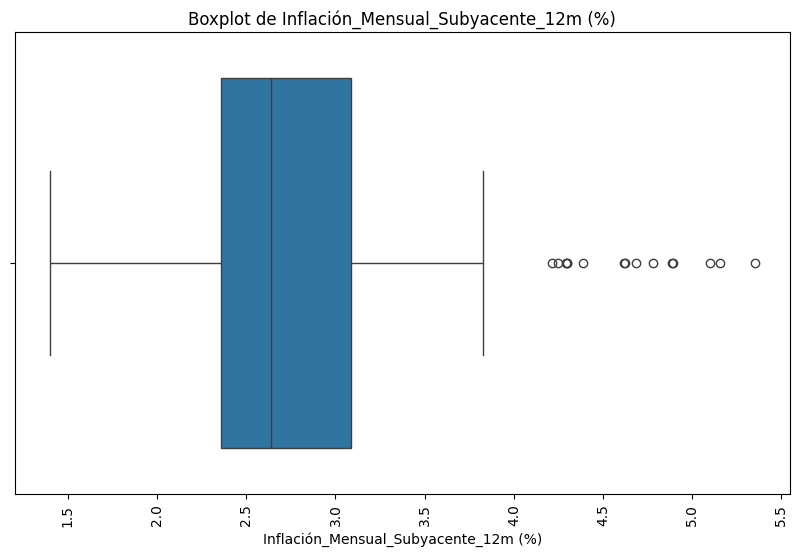

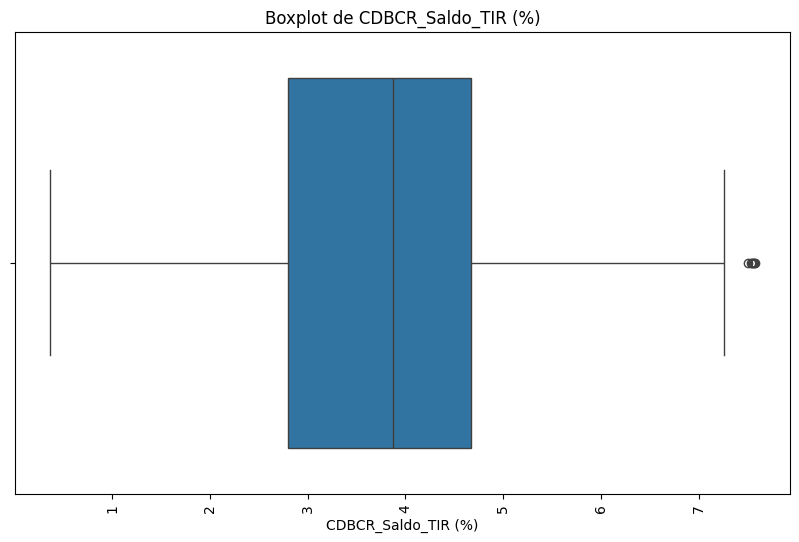

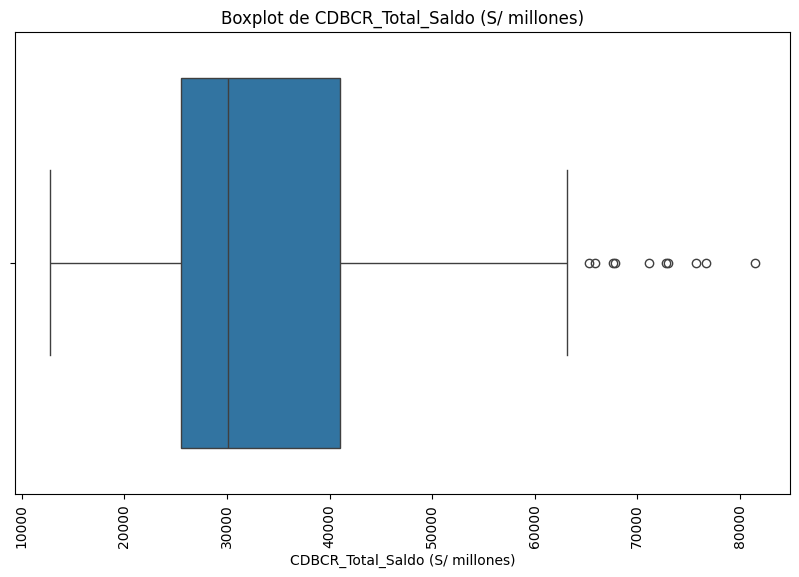

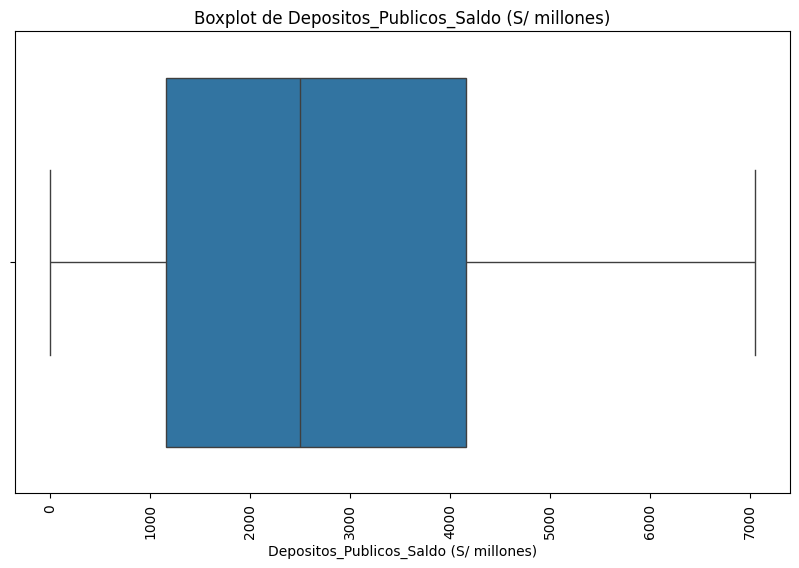

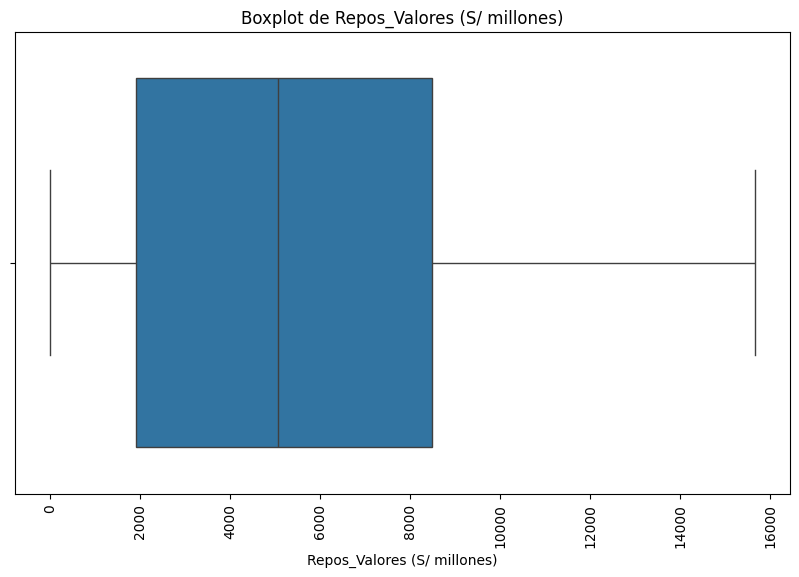

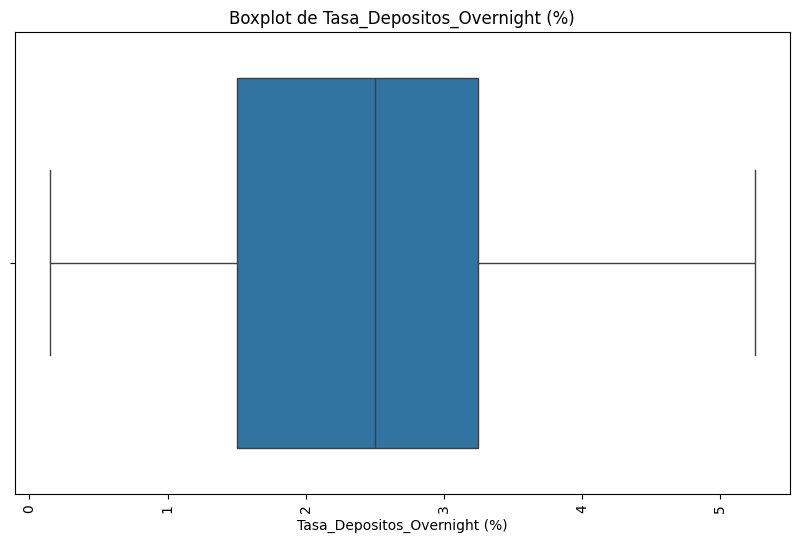

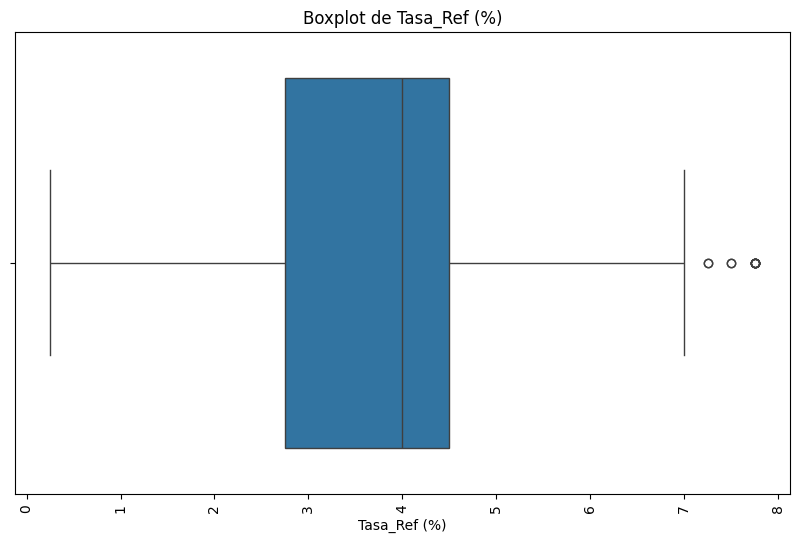

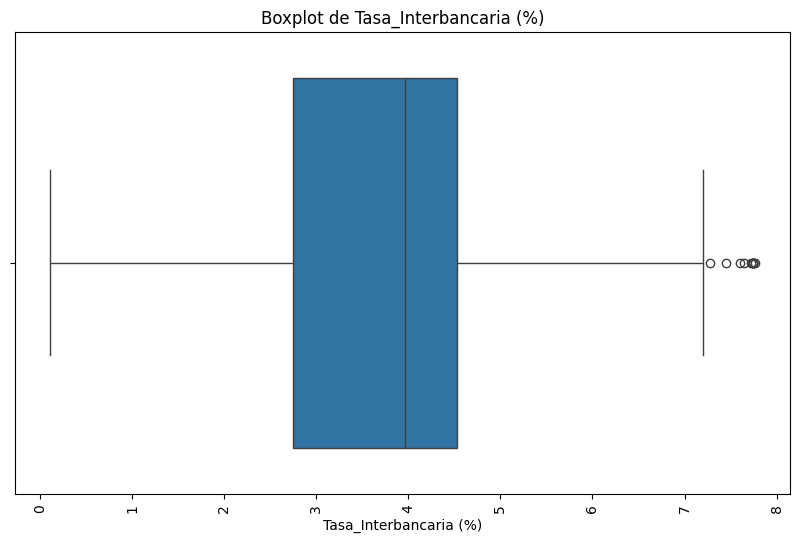

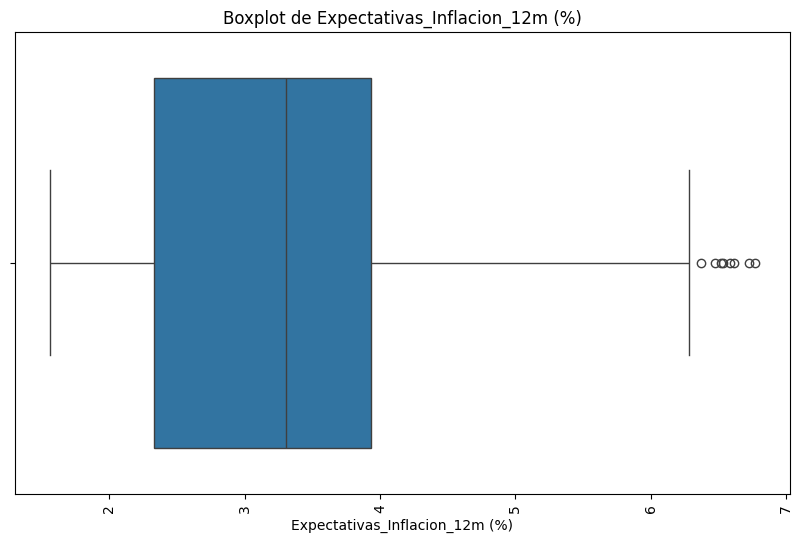

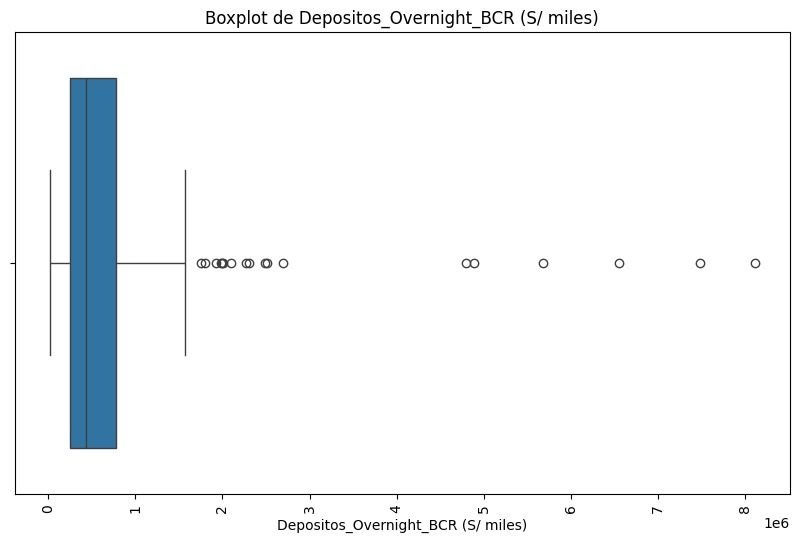

In [8]:
# Definir las columnas numéricas de interés
variables = columnas_numericas.columns

# Crear un boxplot por cada variable
for var in variables:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_bcrp[var])
    plt.title(f'Boxplot de {var}')
    plt.xticks(rotation=90)  # Rotar las etiquetas del eje X para mejor visibilidad
    plt.show()

Interpretacion:

Estos gráficos nos ayudan a entender la distribución de los datos de cada variable. Cada caja representa el 50% de los valores centrales, la línea en el medio es la mediana, y las líneas que se extienden (bigotes) muestran el rango general de los datos.

En los gráficos de las tasas de interés (Tasa_Ref, Tasa_Interbancaria y Tasa_Depositos_Overnight), las cajas son muy estrechas. Esto significa que los valores de estas tasas no varían mucho, lo cual es normal porque el Banco Central las controla. Los puntos que ves fuera de los "bigotes" son valores atípicos, que pueden representar momentos de cambios abruptos en la política monetaria.

En el gráfico de la inflación (IPC), la caja es más ancha, mostrando que este indicador es más volátil que las tasas de interés. Aun así, la mayoría de los datos se agrupan de forma predecible sin tener valores extremadamente altos o bajos.

Finalmente, los gráficos de los saldos (CDBCR_Total_Saldo, Repos_Valores y Depósitos_Públicos_Saldo) tienen cajas muy pequeñas, pero con muchos puntos dispersos por encima. Esto nos dice que, aunque la mayoría de los valores son bajos, hay ocasiones en las que se registran transacciones o saldos excepcionalmente grandes. Estos valores atípicos son comunes en los mercados financieros, ya que reflejan operaciones extraordinarias de gran escala que ocurren con poca frecuencia.


### **1.7.2 Tendencias**



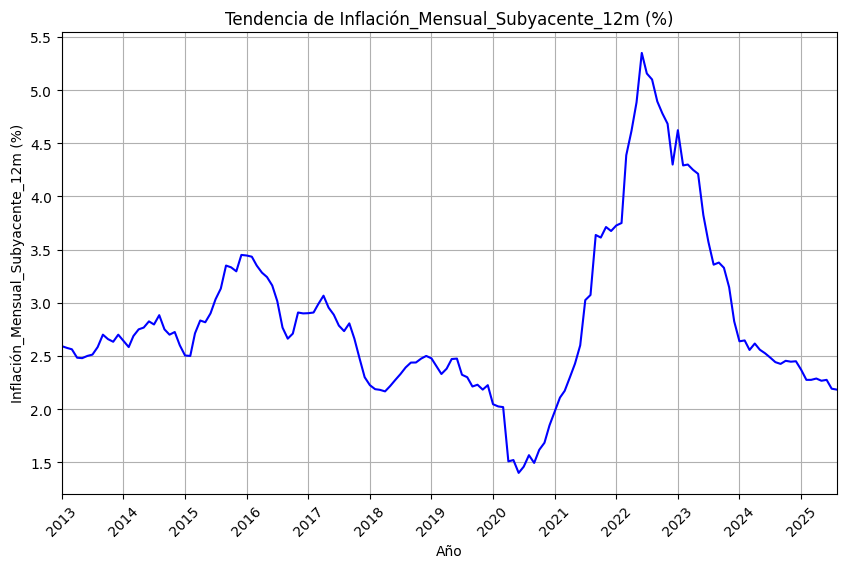

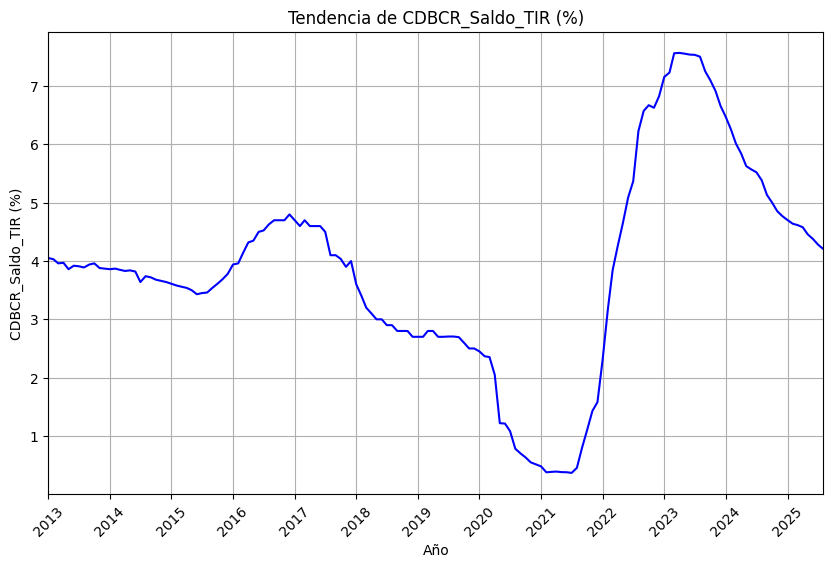

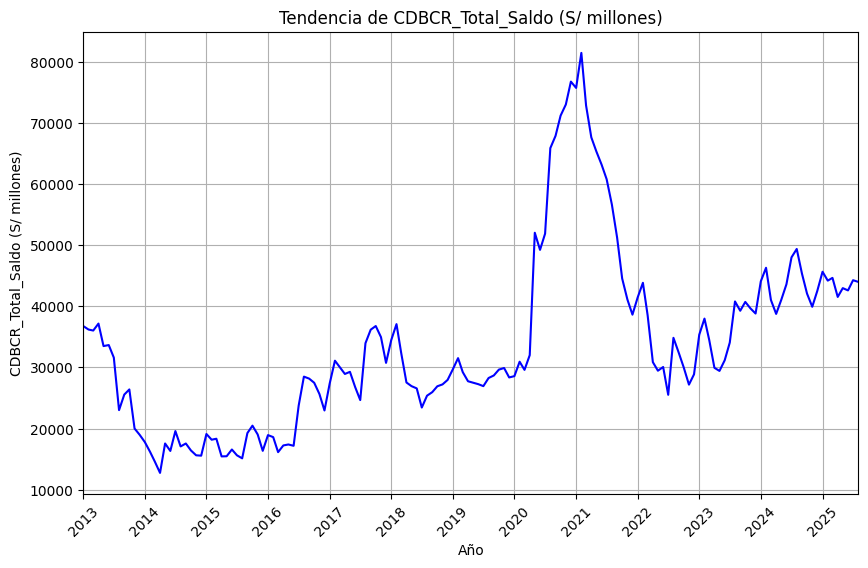

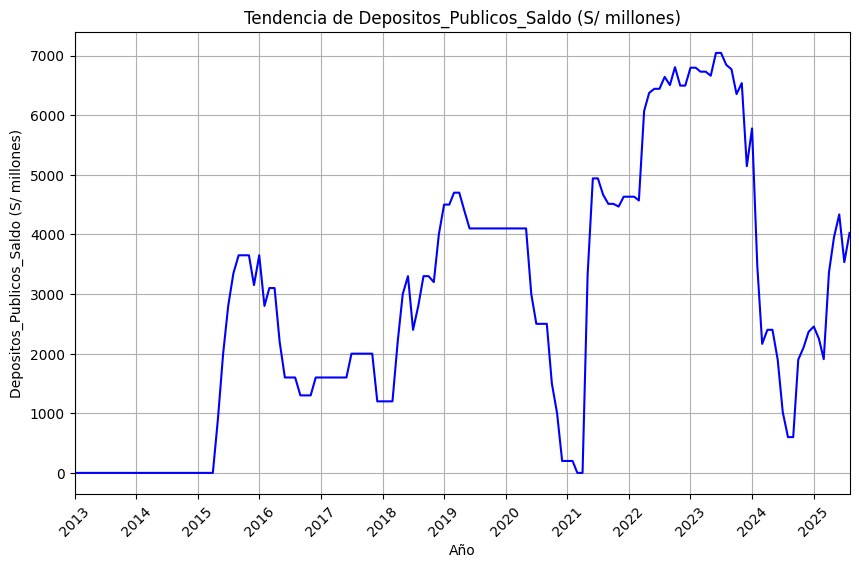

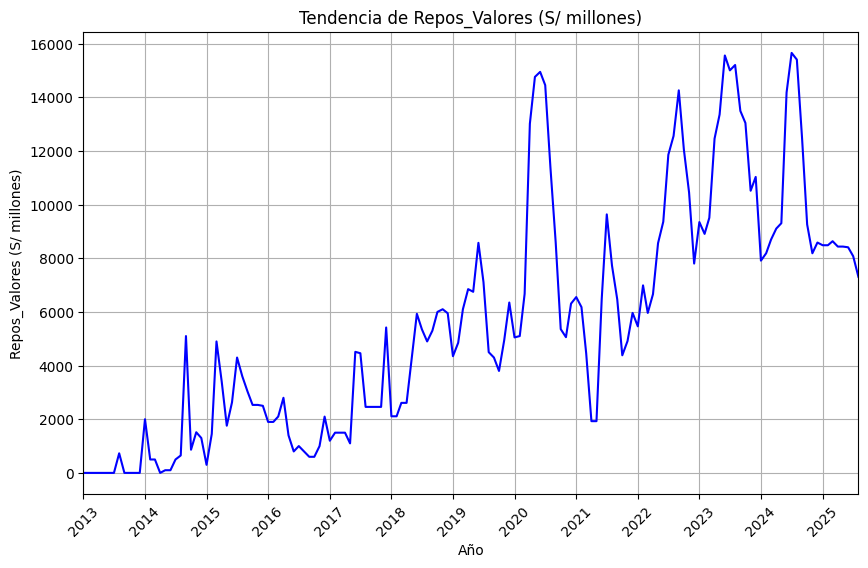

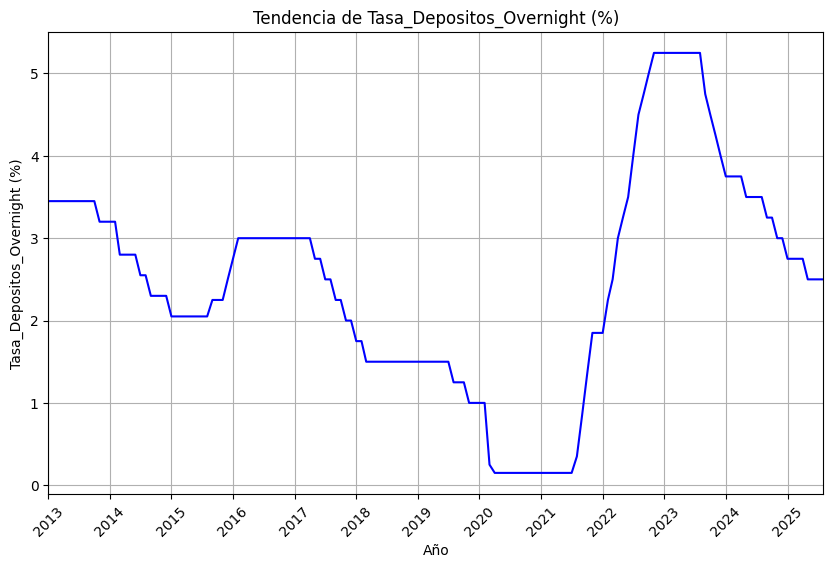

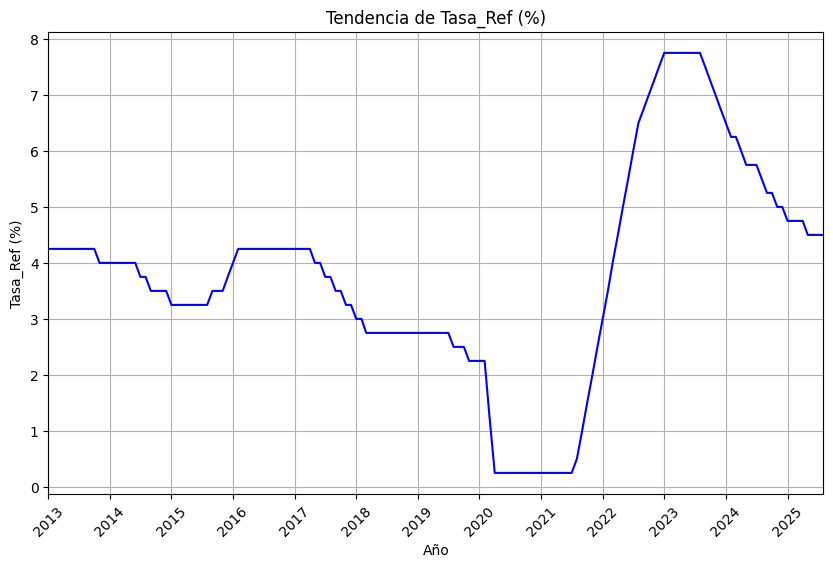

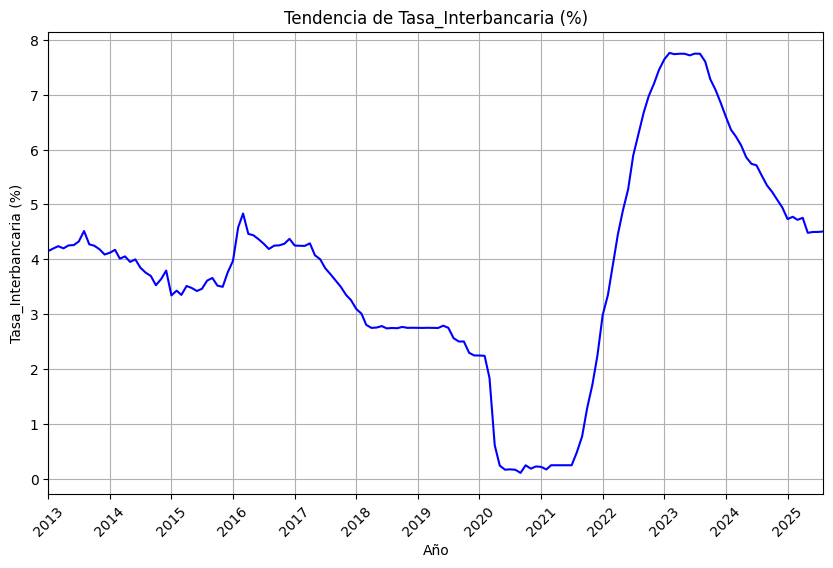

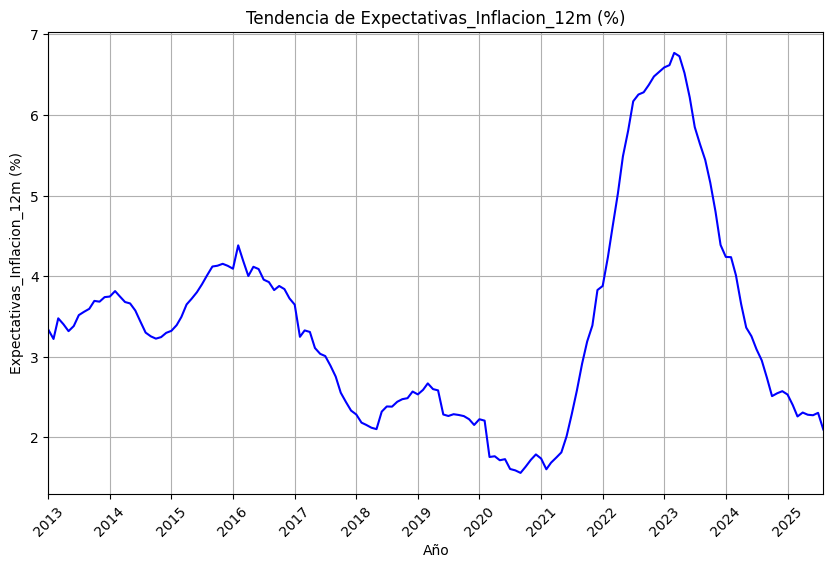

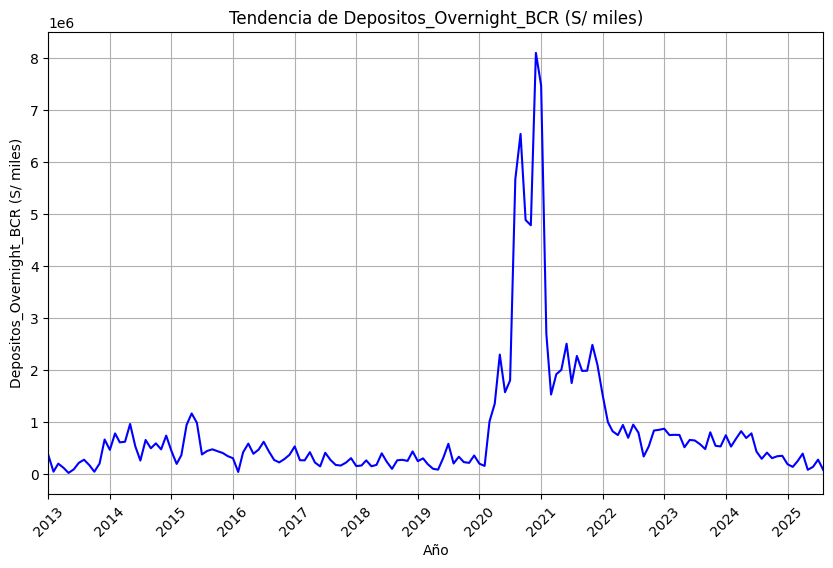

In [9]:

# Crear un diccionario para mapear los meses en español al formato en inglés
meses_esp = {
    'Ene': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Abr': 'Apr', 'May': 'May', 'Jun': 'Jun',
    'Jul': 'Jul', 'Ago': 'Aug', 'Sep': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dic': 'Dec'
}

# Función para convertir las fechas en español al formato inglés
def convertir_mes(fecha):
    mes, año = fecha.split('.')
    mes = meses_esp[mes]  # Reemplazar el mes en español por su equivalente en inglés
    return f'{mes}.{año}'

# Aplicar la función a la columna 'Fecha'
df_bcrp['Fecha'] = df_bcrp['Fecha'].apply(convertir_mes)
df_bcrp['Fecha'] = pd.to_datetime(df_bcrp['Fecha'], format='%b.%Y')

# Definir las columnas numéricas de interés
variables = columnas_numericas.columns

# Obtener el rango de fechas del DataFrame
fecha_min = df_bcrp['Fecha'].min()
fecha_max = df_bcrp['Fecha'].max()

# Crear un gráfico de tendencias para cada variable
for var in variables:
    plt.figure(figsize=(10, 6))

    # Graficar solo la línea, sin puntos
    plt.plot(df_bcrp['Fecha'], df_bcrp[var], linestyle='-', color='b')

    # Configurar el formato del eje X para mostrar solo el año
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Mostrar todos los años del rango de datos
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Mostrar todos los años

    # Limitar el rango del eje X al mínimo y máximo de las fechas en el DataFrame
    plt.xlim([fecha_min, fecha_max])

    # Ajustes del gráfico
    plt.title(f'Tendencia de {var}')
    plt.xlabel('Año')
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()



Interpretacion

Las gráficas muestran varias tendencias en las variables del BCRP. La Tasa de Interés de Referencia, la Tasa de los Depósitos Overnight y la Tasa Interbancaria han exhibido movimientos similares a lo largo del tiempo, con picos de aumento notable. Estas tasas subieron abruptamente alrededor de finales de 2021 y se mantuvieron elevadas, alcanzando un pico en los últimos años del período analizado, lo que refleja una política monetaria más restrictiva para combatir la inflación.

Las expectativas de inflacion a 12m  también muestra una tendencia ascendente general. Si bien presenta fluctuaciones, su valor ha aumentado significativamente, especialmente a partir de 2021. Este aumento coincide con la subida de las tasas de interés, lo que indica que el BCRP ha estado respondiendo de manera activa a las presiones inflacionarias.

Los saldos en S/ millones, como CDBCR_Total_Saldo y Repos_Valores, exhiben una variabilidad considerable. El saldo de los repos ha mostrado un crecimiento notable, lo que podría indicar una mayor intervención del BCRP en el mercado para proveer liquidez. Por otro lado, los Depósitos_Públicos_Saldo muestran picos altos ocasionales, lo que puede reflejar grandes movimientos de fondos del sector público en momentos específicos.

## **1.8 Matriz de correlación**

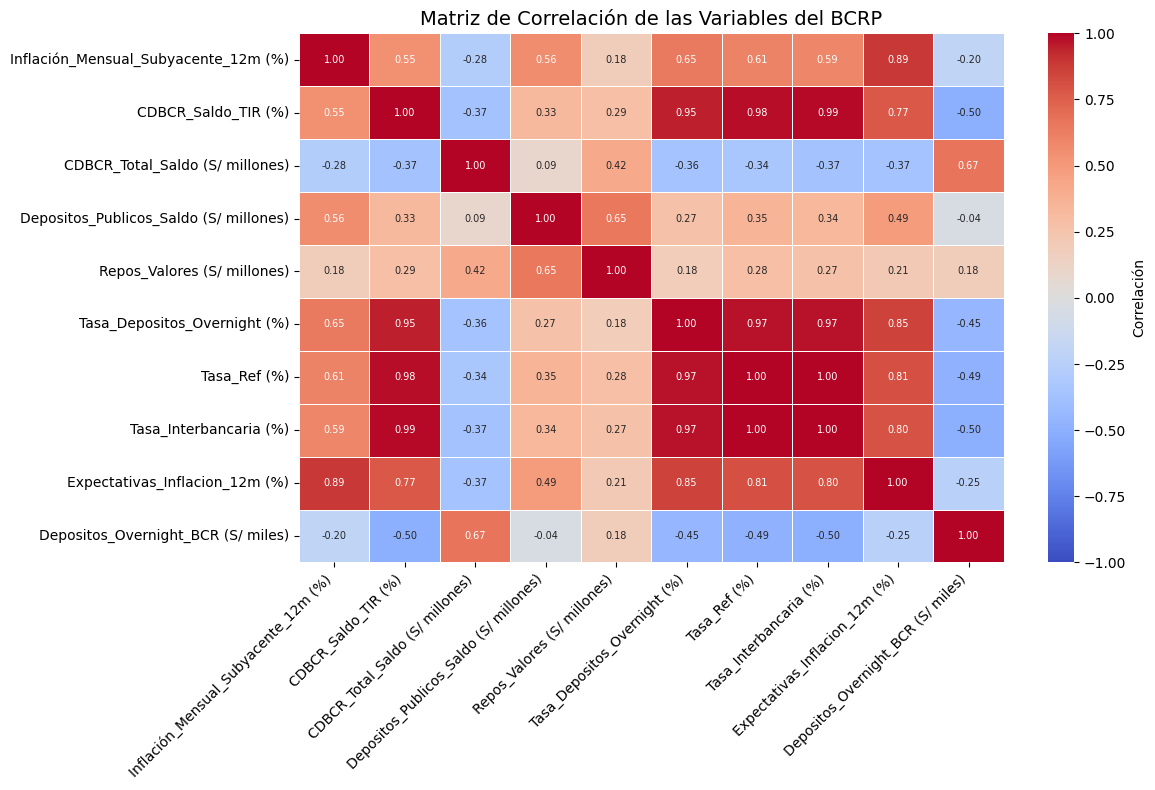

In [10]:

# Excluir la columna 'Fecha' para calcular la correlación solo con las variables numéricas
df_bcrp_sin_fecha = df_bcrp.drop(columns=['Fecha'])

# Calcular la matriz de correlación
correlacion = df_bcrp_sin_fecha.corr()


plt.figure(figsize=(12, 8))

# Crear el heatmap y guardar la barra de color en 'cbar'
ax = sns.heatmap(
    correlacion,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    vmin=-1, vmax=1,
    annot_kws={"size": 7},      # Tamaño de letra dentro del heatmap
    cbar_kws={"label": "Correlación"}  # Etiqueta de la barra de color
)

# Ajustar la barra de color
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)          # Tamaño de letra de los números
cbar.ax.set_ylabel("Correlación", fontsize=10)  # Tamaño de la etiqueta

# Títulos y ejes
plt.title('Matriz de Correlación de las Variables del BCRP', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


Interpretación:
La matriz de correlación muestra que Inflación mensula subyacente mantiene una correlación positiva con la Tasa_de_Referencia, lo que indica que, cuando la primera aumenta, el BCRP tiende a elevar su tasa de política para contener presiones inflacionarias y anclar expectativas. Esta relación se refuerza al observar que la Tasa_de_Referencia también presenta correlaciones positivas con otras tasas del sistema como la Tasa_Interbancaria y la Tasa_Depósitos lo que evidencia que un ajuste en la tasa de política se transmite de manera coherente al resto del mercado monetario. Asimismo, variables como los Depósitos del Sector Privado y los Depósitos del Sector Público muestran correlaciones moderadas con las tasas, reflejando que condiciones monetarias más restrictivas pueden influir en la liquidez y el comportamiento de ahorro del sistema financiero. En contraste, instrumentos de corto plazo como los Repos, Overnight u otros agregados operativos presentan correlaciones más débiles o heterogéneas, lo que sugiere que responden más a intervenciones puntuales de gestión de liquidez que al ciclo monetario general. En conjunto, la matriz confirma que la Inflación y la Tasa_de_Referencia se encuentran en el centro de la dinámica macrofinanciera, articulando los movimientos del resto de variables monetarias del BCRP.

### **1.8.1.CORRELACION ENTRE PARES DE VARIABLES**

In [11]:

# Excluir la columna 'Fecha' para calcular solo las correlaciones de las variables numéricas
df_bcrp_sin_fecha = df_bcrp.drop(columns=['Fecha'])

# Calcular la matriz de correlación
correlacion = df_bcrp_sin_fecha.corr()

# Convertir la matriz de correlación en un formato largo (pairs de variables)
correlacion_larga = correlacion.unstack()

# Filtrar los pares con correlación absoluta mayor A 0.8
correlacion_fuerte = correlacion_larga[(correlacion_larga.abs() > 0.8) & (correlacion_larga != 1)]

# Ordenar los pares de correlación de mayor a menor
correlacion_fuerte = correlacion_fuerte.sort_values(ascending=False)

# Mostrar los pares de variables más correlacionadas
print("Pares de variables con correlación más alta:")
print(correlacion_fuerte)

Pares de variables con correlación más alta:
Tasa_Interbancaria (%)                Tasa_Ref (%)                            0.997973
Tasa_Ref (%)                          Tasa_Interbancaria (%)                  0.997973
CDBCR_Saldo_TIR (%)                   Tasa_Interbancaria (%)                  0.986235
Tasa_Interbancaria (%)                CDBCR_Saldo_TIR (%)                     0.986235
CDBCR_Saldo_TIR (%)                   Tasa_Ref (%)                            0.983514
Tasa_Ref (%)                          CDBCR_Saldo_TIR (%)                     0.983514
Tasa_Depositos_Overnight (%)          Tasa_Ref (%)                            0.974326
Tasa_Ref (%)                          Tasa_Depositos_Overnight (%)            0.974326
Tasa_Depositos_Overnight (%)          Tasa_Interbancaria (%)                  0.971189
Tasa_Interbancaria (%)                Tasa_Depositos_Overnight (%)            0.971189
Tasa_Depositos_Overnight (%)          CDBCR_Saldo_TIR (%)                     0.94977

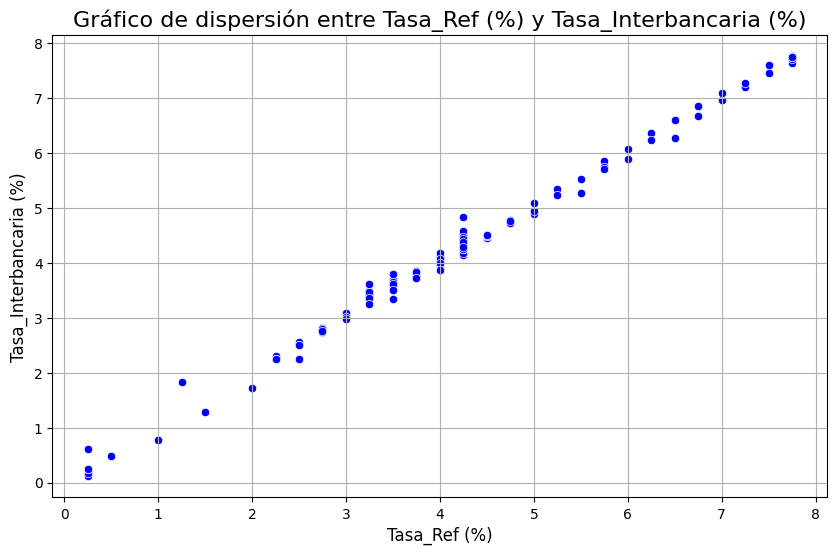

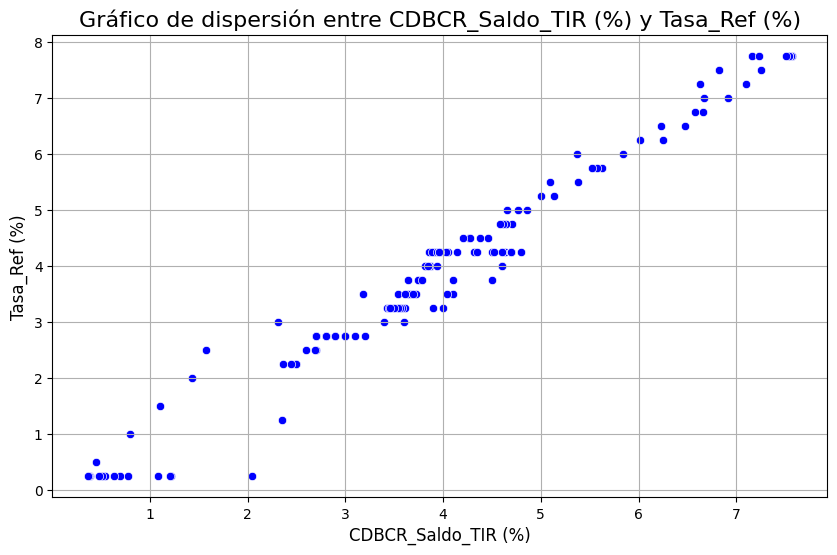

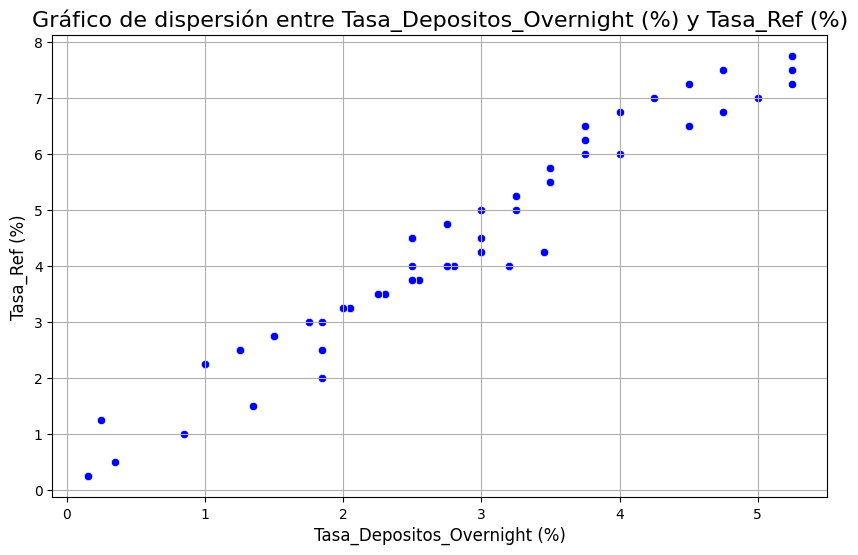

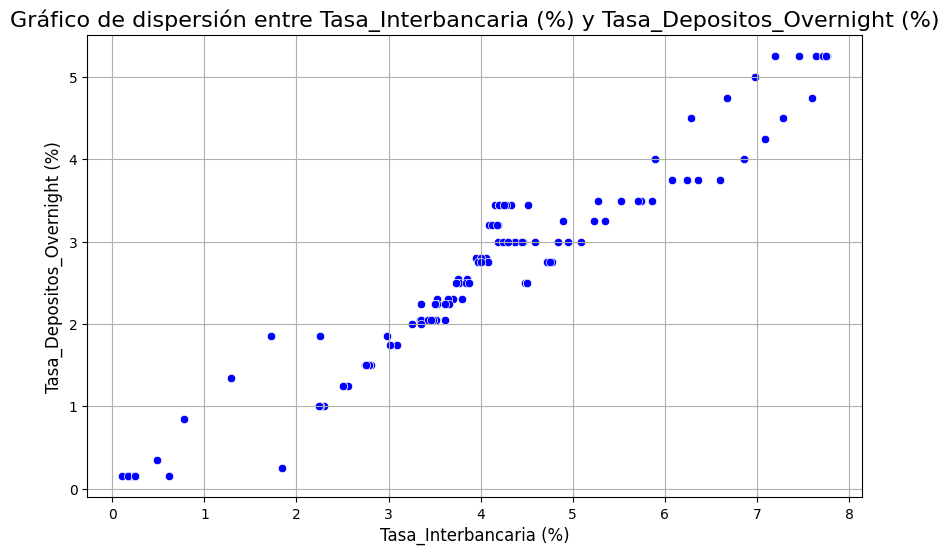

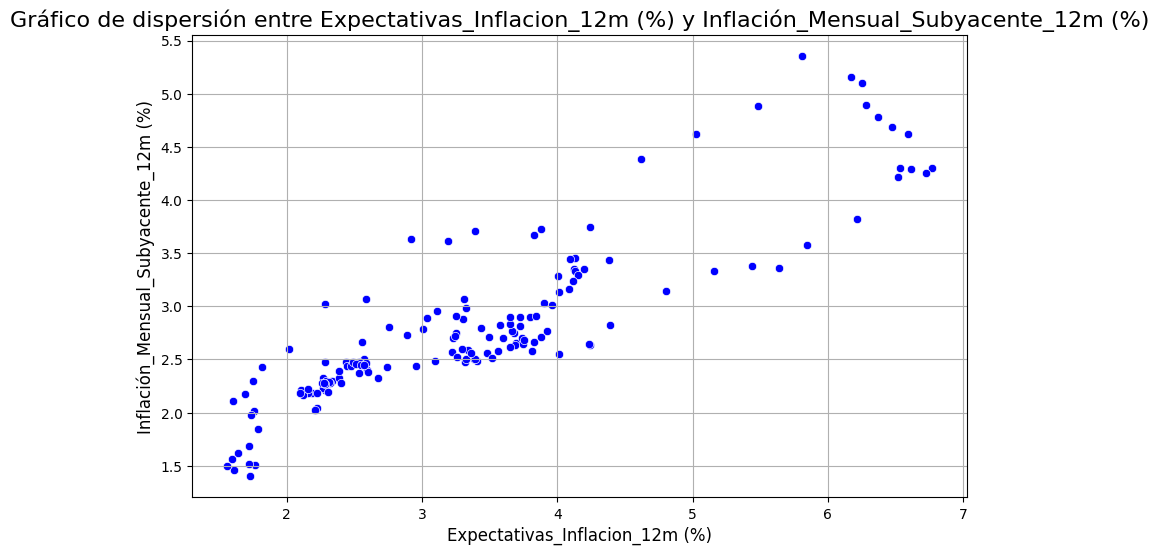

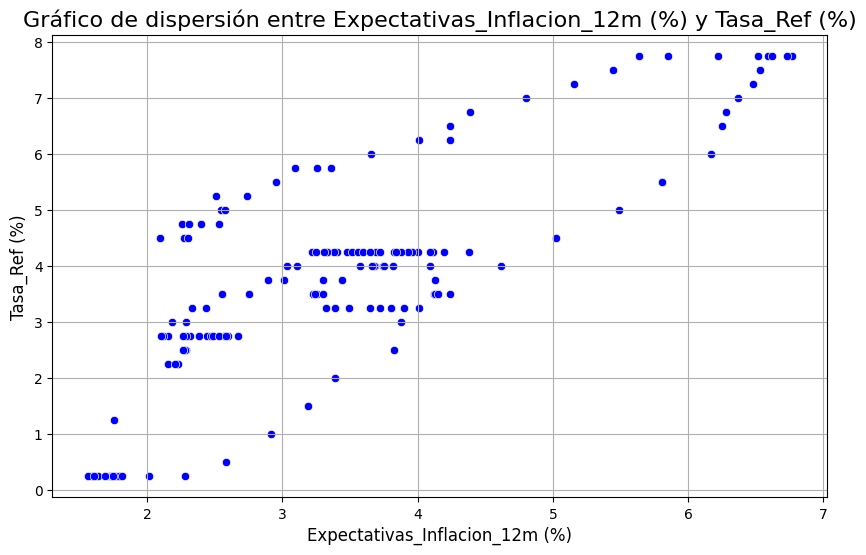

In [12]:
# Crear gráficos de dispersión para los pares con correlaciones más altas
pares_correlacionados = [
    ('Tasa_Ref (%)', 'Tasa_Interbancaria (%)'),
    ('CDBCR_Saldo_TIR (%)', 'Tasa_Ref (%)'),
    ('Tasa_Depositos_Overnight (%)', 'Tasa_Ref (%)'),
    ('Tasa_Interbancaria (%)', 'Tasa_Depositos_Overnight (%)'),
  ('Expectativas_Inflacion_12m (%)', 'Inflación_Mensual_Subyacente_12m (%)'),
    ('Expectativas_Inflacion_12m (%)', 'Tasa_Ref (%)'),

]

# Crear gráficos de dispersión para cada par
for var1, var2 in pares_correlacionados:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df_bcrp[var1], y=df_bcrp[var2], color='blue')
    plt.title(f'Gráfico de dispersión entre {var1} y {var2}', fontsize=16)
    plt.xlabel(var1, fontsize=12)
    plt.ylabel(var2, fontsize=12)
    plt.grid(True)
    plt.show()

Interpretación:

Los pares de variables seleccionados muestran una dinámica coherente con la transmisión de la política monetaria del BCRP. La relación casi perfecta entre Tasa_Ref (%) y Tasa_Interbancaria (%) confirma que los cambios en la tasa de referencia se trasladan de forma inmediata al mercado interbancario, mecanismo central mediante el cual el banco central regula la liquidez del sistema. Asimismo, la fuerte correlación entre Tasa_Ref (%) y Tasa_Depositos_Overnight (%), así como entre Tasa_Ref (%) y CDBCR_Saldo_TIR (%), evidencia que la señal de política se transmite hacia las tasas de muy corto plazo y hacia los instrumentos de absorción de liquidez, mostrando consistencia en la estructura monetaria. A su vez, la asociación entre Tasa_Interbancaria (%) y Tasa_Depositos_Overnight (%) muestra que ambas tasas se mueven de manera conjunta en respuesta a las operaciones del BCRP. Por otra parte, la correlación elevada entre Expectativas_Inflacion_12m (%) e Inflación_Mensual_Subyacente_12m (%) sugiere que los agentes forman sus expectativas inflacionarias observando el comportamiento reciente de la inflación subyacente. Finalmente, la relación positiva entre Expectativas_Inflacion_12m (%) y Tasa_Ref (%) refleja que, cuando las expectativas aumentan, el mercado anticipa una postura monetaria más restrictiva, consistente con el esquema de metas de inflación. En conjunto, estos pares muestran una transmisión monetaria eficiente y una articulación estrecha entre inflación, expectativas y tasas de política.

# **TG 2-3**

## **2.1. semilla y reproducibilidad**

In [13]:
# Importamos las librerías necesarias
warnings.filterwarnings('ignore')  # Ignora las advertencias para evitar mensajes innecesarios

RANDOM_STATE = 42           # Fijamos una semilla para reproducibilidad
np.random.seed(RANDOM_STATE)  # Establecemos la semilla aleatoria en NumPy


sns.set(style='whitegrid', context='talk')  # Configura el estilo visual de las gráficas


# Imprimimos las versiones de las librerías
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scikit-learn', sklearn.__version__)
print('statsmodels', statsmodels.__version__)




numpy 2.0.2
pandas 2.2.2
scikit-learn 1.6.1
statsmodels 0.14.5


## **2.1.Renombra el  df_bcrp a df**

In [14]:
# Asegurar que la columna Fecha esté en formato datetime
df_bcrp['Fecha'] = pd.to_datetime(df_bcrp['Fecha'], errors='coerce')

# Ordenar por la fecha
df_bcrp = df_bcrp.sort_values('Fecha').reset_index(drop=True)

# Colocar Fecha como índice
df_bcrp.set_index('Fecha', inplace=True)

# Renombrar df_bcrp como df para trabajar en los gráficos
df = df_bcrp.copy()

print('Dimensiones del df:', df.shape)
df.head()


Dimensiones del df: (152, 10)


,Inflación_Mensual_Subyacente_12m (%),CDBCR_Saldo_TIR (%),CDBCR_Total_Saldo (S/ millones),Depositos_Publicos_Saldo (S/ millones),Repos_Valores (S/ millones),Tasa_Depositos_Overnight (%),Tasa_Ref (%),Tasa_Interbancaria (%),Expectativas_Inflacion_12m (%),Depositos_Overnight_BCR (S/ miles)
Fecha,,,,,,,,,,
2013-01-01,2.591667,4.053,36762.4,0.0,0.0,3.45,4.25,4.1518,3.338063,367807.0
2013-02-01,2.575000,4.030,36200.2,0.0,0.0,3.45,4.25,4.2008,3.221990,47590.0
2013-03-01,2.562500,3.960,36034.7,0.0,0.0,3.45,4.25,4.2404,3.477736,201773.0
2013-04-01,2.483333,3.970,37175.0,0.0,0.0,3.45,4.25,4.2005,3.404137,122430.0
2013-05-01,2.479167,3.860,33493.0,0.0,0.0,3.45,4.25,4.2542,3.318773,23520.0


## **2.2 Construcción del problema supervisado**

In [15]:
target_col = 'Inflación_Mensual_Subyacente_12m (%)'   # Variable objetivo
expect_col = 'Expectativas_Inflacion_12m (%)'          # Expectativas de inflación
tir_col = 'Tasa_Ref (%)'                               # Tasa de referencia
monetary_cols = ['CDBCR_Total_Saldo (S/ millones)', 'CDBCR_Saldo_TIR (%)', 'Depositos_Publicos_Saldo (S/ millones)']  # Variables monetarias

# Crear rezagos de la inflación (1 a 3 meses)
for lag in range(1,4):
    df[f'inflacion_12m_lag{lag}'] = df[target_col].shift(lag)

df['Expectativas_Inflacion_12m_lag1'] = df[expect_col].shift(1)   # Rezago 1 de expectativas

# Crear rezagos de la tasa de referencia (0 a 3 meses)
for lag in range(0,4):
    df[f'TIR_lag{lag}'] = df[tir_col].shift(lag)

# Crear rezago 1 para cada variable monetaria
for col in monetary_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

# Lista de variables predictoras
features = ['inflacion_12m_lag1','inflacion_12m_lag2','inflacion_12m_lag3',
            'Expectativas_Inflacion_12m_lag1','TIR_lag0','TIR_lag1','TIR_lag2','TIR_lag3'] + [f'{c}_lag1' for c in monetary_cols]

# Verificar que todas las columnas necesarias existan
missing = [c for c in features + [target_col] if c not in df.columns]
if missing:
    raise ValueError('Faltan columnas: ' + ', '.join(missing))

# Crear dataset final para el modelo y eliminar filas con NaN
df_model = df[features + [target_col]].dropna().copy()

print('Observaciones para modelado:', df_model.shape)
df_model.head()   # Mostrar primeras filas del dataset del modelo


Observaciones para modelado: (149, 12)


,inflacion_12m_lag1,inflacion_12m_lag2,inflacion_12m_lag3,Expectativas_Inflacion_12m_lag1,TIR_lag0,TIR_lag1,TIR_lag2,TIR_lag3,CDBCR_Total_Saldo (S/ millones)_lag1,CDBCR_Saldo_TIR (%)_lag1,Depositos_Publicos_Saldo (S/ millones)_lag1,Inflación_Mensual_Subyacente_12m (%)
Fecha,,,,,,,,,,,,
2013-04-01,2.562500,2.575000,2.591667,3.477736,4.25,4.25,4.25,4.25,36034.7,3.96,0.0,2.483333
2013-05-01,2.483333,2.562500,2.575000,3.404137,4.25,4.25,4.25,4.25,37175.0,3.97,0.0,2.479167
2013-06-01,2.479167,2.483333,2.562500,3.318773,4.25,4.25,4.25,4.25,33493.0,3.86,0.0,2.500000
2013-07-01,2.500000,2.479167,2.483333,3.382053,4.25,4.25,4.25,4.25,33661.1,3.92,0.0,2.512500
2013-08-01,2.512500,2.500000,2.479167,3.517619,4.25,4.25,4.25,4.25,31610.9,3.91,0.0,2.583333



En esta etapa se generó la estructura temporal del modelo supervisado, asegurando la **causalidad económica** mediante el uso de rezagos.  
Cada observación de la inflación subyacente interanual en \( t \) se explica por:

- Sus **propios rezagos** (1 a 3 meses), que capturan la **persistencia inflacionaria**.  
- Las **expectativas de inflación a 12 meses** rezagadas en un período, que reflejan el canal de expectativas.  
- Los **rezagos contemporáneos y pasados de la tasa de referencia (TIR)**, para capturar los efectos de política monetaria.  
- Variables de **liquidez del BCRP** (CD BCRP, tasa de los CD y depósitos públicos), todas en rezago 1, como controles monetarios.

El conjunto final incluye **149 observaciones y 12 variables**, lo que indica una base temporal continua y consistente para estimar la inflación subyacente sin pérdida de información relevante.


## **2.3. Separación temporal y validación**

In [16]:
n = len(df_model)                                     # Número total de observaciones
test_size = int(np.ceil(0.25 * n))                    # Tamaño del conjunto de prueba (25%)
train_size = n - test_size                            # Tamaño del conjunto de entrenamiento

train = df_model.iloc[:train_size].copy()             # Datos de entrenamiento
test = df_model.iloc[train_size:].copy()              # Datos de prueba

X_train = train[features]; y_train = train[target_col]  # Variables predictoras y objetivo (train)
X_test = test[features]; y_test = test[target_col]      # Variables predictoras y objetivo (test)

print('Train', X_train.shape, 'Test', X_test.shape)   # Mostrar tamaños de los conjuntos

tscv = TimeSeriesSplit(n_splits=5)                    # Validación cruzada para series temporales


Train (111, 11) Test (38, 11)



Se dividió la muestra total en **75% para entrenamiento (111 observaciones)** y **25% para prueba (38 observaciones)**, manteniendo el **orden cronológico** de las series.  
Esto asegura que las observaciones futuras nunca se utilicen para predecir el pasado, preservando la lógica temporal del proceso inflacionario.

Además, se implementó una **validación cruzada temporal (TimeSeriesSplit, 5 pliegues)**, que evalúa la estabilidad de los modelos a lo largo del tiempo y permite estimar su capacidad de generalización en distintos subperíodos.  
Esta metodología es especialmente adecuada para **series macroeconómicas** donde existe dependencia temporal entre observaciones.


## **2.4. Baselines**

In [17]:
# Baseline mean
y_pred_base_mean = np.repeat(y_train.mean(), len(y_test))
mse_base_mean = mean_squared_error(y_test, y_pred_base_mean)
r2_base_mean = r2_score(y_test, y_pred_base_mean)
# Baseline persistence
y_pred_persistence = X_test['inflacion_12m_lag1'].values
mse_persistence = mean_squared_error(y_test, y_pred_persistence)
r2_persistence = r2_score(y_test, y_pred_persistence)
print('Baseline mean MSE:', mse_base_mean, 'R2:', r2_base_mean)
print('Baseline persistence MSE:', mse_persistence, 'R2:', r2_persistence)

Baseline mean MSE: 1.226592148295128 R2: -0.29006646247076673
Baseline persistence MSE: 0.024965620431286244 R2: 0.9737424459483593




Se estimaron dos modelos de referencia (baselines) que sirven como punto de comparación para evaluar el desempeño de los modelos supervisados posteriores (OLS, Ridge, RF, XGB):

---

**1️. Modelo baseline de la media**

Este modelo predice la inflación futura suponiendo que será igual al promedio histórico de la inflación observada en el conjunto de entrenamiento:

$ \hat{\pi}_t = \bar{\pi}_{\text{train}} $

En este caso, el resultado fue:
 $ \text{MSE} = 1.2266, \quad R^2 = -0.29 $

El \( R^2 \) negativo indica que el modelo **no explica la variabilidad** de la inflación mejor que una simple media — es decir, se comporta peor que una predicción constante sin estructura temporal.

---

**2️. Modelo baseline de persistencia**

Este modelo asume que la inflación actual será igual a la del mes anterior, lo cual es típico en series macroeconómicas con inercia:

$ \hat{\pi}_t = \pi_{t-1} $

El resultado obtenido fue:
$\text{MSE} = 0.0250, \quad R^2 = 0.97$

El baseline utilizado corresponde a un modelo de **persistencia pura**, que toma como predicción de $ \pi_t $ el último dato disponible $ \pi_{t-1}$. Este baseline es perfectamente consistente con un enfoque one-step-ahead, pues al momento de pronosticar el mes $t$ la observación $t-1$ ya es conocida. Su inclusión es útil porque establece un punto de comparación mínimo: cualquier modelo predictivo debe superar, al menos, la información contenida en la propia inercia inflacionaria. En nuestro caso, la alta persistencia de la inflación subyacente hace que este baseline tenga un desempeño muy fuerte, lo que resalta el desafío de mejorar sobre él.




## **2.5. OLS (statsmodels) — estimación e inferencia**

In [18]:


X_tr_sm = sm.add_constant(X_train)               # Agrega constante (intercepto) al modelo
ols_final = sm.OLS(y_train, X_tr_sm).fit()       # Ajusta un modelo OLS (mínimos cuadrados)
display(ols_final.summary())                     # Muestra el resumen del modelo

y_pred_ols = ols_final.predict(sm.add_constant(X_test))   # Predicciones sobre el conjunto de prueba

mse_ols_test = mean_squared_error(y_test, y_pred_ols)     # Error cuadrático medio en test
r2_ols_test = r2_score(y_test, y_pred_ols)                # R2 en test

print('OLS Test MSE: {:.6f}, R2: {:.6f}'.format(mse_ols_test, r2_ols_test))   # Métricas del modelo


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Inflación_Mensual_Subyacente_12m (%)   R-squared:                       0.972
Model:                                              OLS   Adj. R-squared:                  0.969
Method:                                   Least Squares   F-statistic:                     316.1
Date:                                  Fri, 28 Nov 2025   Prob (F-statistic):           7.05e-72
Time:                                          18:53:41   Log-Likelihood:                 87.890
No. Observations:                                   111   AIC:                            -151.8
Df Residuals:                                        99   BIC:                            -119.3
Df Model:                                            11                                         
Covariance Type:                              nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -0.0639      0.123     -0.517      0.606      -0.309       0.181
inflacion_12m_lag1                              0.9865      0.100      9.817      0.000       0.787       1.186
inflacion_12m_lag2                              0.1496      0.142      1.055      0.294      -0.132       0.431
inflacion_12m_lag3                             -0.2638      0.103     -2.567      0.012      -0.468      -0.060
Expectativas_Inflacion_12m_lag1                 0.1039      0.039      2.653      0.009       0.026       0.182
TIR_lag0                                        0.2141      0.074      2.875      0.005       0.066       0.362
TIR_lag1                                       -0.1171      0.125     -0.933      0.353      -0.366       0.132
TIR_lag2                                       -0.1707      0.128     -1.335      0.185      -0.425       0.083
TIR_lag3                                        0.0659      0.084      0.781      0.437      -0.102       0.233
CDBCR_Total_Saldo (S/ millones)_lag1         2.832e-06   1.39e-06      2.035      0.045    7.09e-08    5.59e-06
CDBCR_Saldo_TIR (%)_lag1                        0.0044      0.047      0.094      0.925      -0.088       0.097
Depositos_Publicos_Saldo (S/ millones)_lag1  1.033e-05   9.06e-06      1.141      0.257   -7.64e-06    2.83e-05
==============================================================================
Omnibus:                       19.154   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.041
Skew:                           0.792   Prob(JB):                     3.00e-07
Kurtosis:                       4.996   Cond. No.                     6.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OLS Test MSE: 0.058149, R2: 0.938842



El modelo OLS constituye la base econométrica del análisis, ya que permite identificar los **determinantes estructurales** de la inflación subyacente interanual mediante una especificación lineal con rezagos y variables monetarias.

Su forma general puede expresarse de manera compacta como:

$
\pi_t = \alpha +
\sum_{i=1}^{3} \beta_i \pi_{t-i} +
\gamma E_{t-1}[\pi_{t+12}] +
\sum_{i=0}^{3} \delta_i \text{TIR}_{t-i} +
\boldsymbol{\theta}' \mathbf{Z}_{t-1} +
\varepsilon_t
$

donde:  
- $\pi_t$: inflación subyacente interanual.  
- $E_{t-1}[\pi_{t+12}]$: expectativas de inflación a 12 meses (rezagadas).  
- $\text{TIR}_{t-i}$: tasa de referencia del BCRP y sus rezagos.  
- $\mathbf{Z}_{t-1}$: vector de controles monetarios (CD BCRP, tasa de CDBCR y depósitos públicos).  
- $\varepsilon_t$: término de error aleatorio.

---

El modelo OLS logra un R² de 0.94 en el conjunto de prueba, confirmando su notable poder de predicción a pesar de su sencillez. Los coeficientes estimados reflejan relaciones económicamente coherentes: la inflación del mes previo ejerce un efecto dominante, reforzando la idea de persistencia; las expectativas de inflación tienen un impacto positivo y estadísticamente significativo, lo que sugiere que las percepciones de los agentes económicos efectivamente se traducen en presiones de precios; y la tasa de referencia actual también aparece con un coeficiente positivo, probablemente reflejando la respuesta de la política monetaria ante presiones inflacionarias.

En conjunto, el OLS logra reproducir con precisión la dinámica inflacionaria sin sobreajustarse, capturando tanto la inercia estructural del proceso como las señales contemporáneas de la política monetaria y las expectativas.


## **2.6. Diagnóstico de residuos y heterocedasticidad**

In [19]:
# Test de heterocedasticidad y autocorrelación

bp = het_breuschpagan(ols_final.resid, ols_final.model.exog)
labels = ['LM Stat', 'LM pvalue', 'F Stat', 'F pvalue']
print('Breusch–Pagan:', dict(zip(labels, bp)))
print('Durbin–Watson:', durbin_watson(ols_final.resid))

# Estimación con errores robustos Newey–West (HAC)
ols_nw = ols_final.get_robustcov_results(cov_type='HAC', maxlags=4)
print("\n--- OLS con errores robustos Newey–West ---")
display(ols_nw.summary())


Breusch–Pagan: {'LM Stat': np.float64(24.380998819841718), 'LM pvalue': np.float64(0.011219146566648172), 'F Stat': np.float64(2.5332662162911173), 'F pvalue': np.float64(0.007353254278300434)}
Durbin–Watson: 1.9173720017618188

--- OLS con errores robustos Newey–West ---


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Inflación_Mensual_Subyacente_12m (%)   R-squared:                       0.972
Model:                                              OLS   Adj. R-squared:                  0.969
Method:                                   Least Squares   F-statistic:                     395.7
Date:                                  Fri, 28 Nov 2025   Prob (F-statistic):           1.41e-76
Time:                                          18:53:41   Log-Likelihood:                 87.890
No. Observations:                                   111   AIC:                            -151.8
Df Residuals:                                        99   BIC:                            -119.3
Df Model:                                            11                                         
Covariance Type:                                    HAC                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -0.0639      0.143     -0.447      0.656      -0.348       0.220
inflacion_12m_lag1                              0.9865      0.096     10.321      0.000       0.797       1.176
inflacion_12m_lag2                              0.1496      0.156      0.959      0.340      -0.160       0.459
inflacion_12m_lag3                             -0.2638      0.111     -2.383      0.019      -0.483      -0.044
Expectativas_Inflacion_12m_lag1                 0.1039      0.041      2.520      0.013       0.022       0.186
TIR_lag0                                        0.2141      0.074      2.879      0.005       0.067       0.362
TIR_lag1                                       -0.1171      0.127     -0.922      0.359      -0.369       0.135
TIR_lag2                                       -0.1707      0.101     -1.693      0.094      -0.371       0.029
TIR_lag3                                        0.0659      0.078      0.848      0.398      -0.088       0.220
CDBCR_Total_Saldo (S/ millones)_lag1         2.832e-06    1.7e-06      1.669      0.098   -5.35e-07     6.2e-06
CDBCR_Saldo_TIR (%)_lag1                        0.0044      0.037      0.118      0.906      -0.069       0.078
Depositos_Publicos_Saldo (S/ millones)_lag1  1.033e-05   8.61e-06      1.200      0.233   -6.76e-06    2.74e-05
==============================================================================
Omnibus:                       19.154   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.041
Skew:                           0.792   Prob(JB):                     3.00e-07
Kurtosis:                       4.996   Cond. No.                     6.42e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
[2] The condition number is large, 6.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Los resultados del test de Breusch–Pagan indican cierta heterocedasticidad residual, coherente con la presencia de episodios de mayor volatilidad durante los años de shocks externos. Sin embargo, el estadístico de Durbin–Watson ( aprox 1.9) y la estabilidad del R² muestran que el modelo no sufre autocorrelación seria ni pérdida de capacidad predictiva.

La corrección con errores robustos de Newey–West confirma que la estructura de los coeficientes se mantiene estable, lo cual refuerza la validez del modelo para fines de pronóstico. En términos prácticos, esto significa que las fluctuaciones residuales responden a factores transitorios o exógenos, como por ejemplo: shocks de oferta o movimientos globales, más que a deficiencias estructurales en la especificación.

## **2.7. Multicolinealidad y PCA**

,var,VIF
7,TIR_lag2,241.808269
6,TIR_lag1,235.601148
0,const,125.620379
8,TIR_lag3,104.956679
5,TIR_lag0,84.984366
2,inflacion_12m_lag2,54.011341
1,inflacion_12m_lag1,30.789537
10,CDBCR_Saldo_TIR (%)_lag1,29.384236
3,inflacion_12m_lag3,25.260734
4,Expectativas_Inflacion_12m_lag1,9.642051


Varianza explicada (PC1, PC2): [0.80730268 0.13526325]


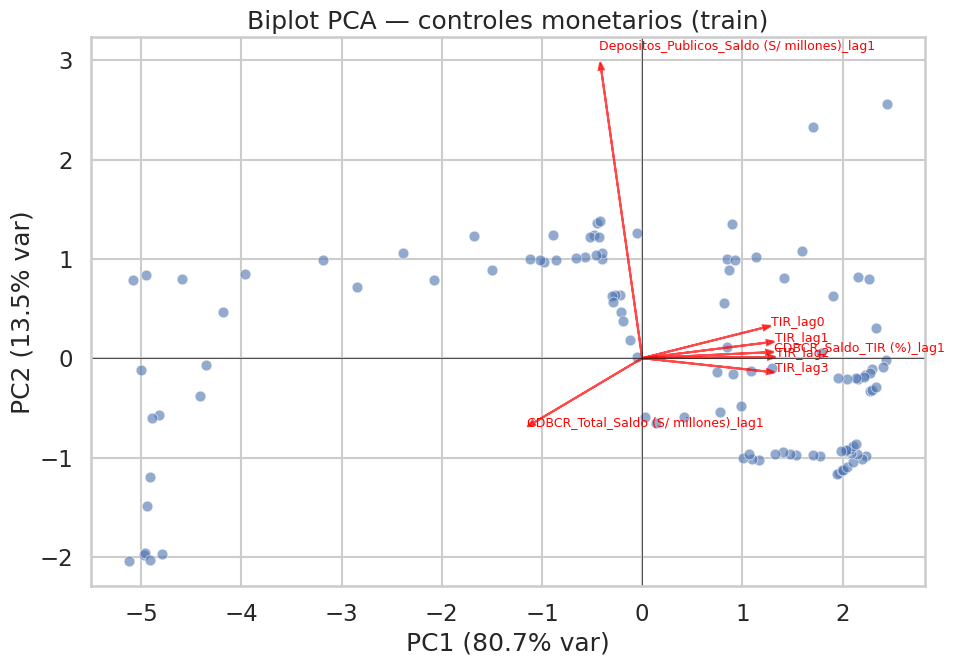

In [20]:


X_vif = sm.add_constant(X_train)   # Agrega constante para el cálculo de VIF
vif = pd.DataFrame({
    'var': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})                                   # Calcula el VIF de cada variable
vif = vif.sort_values('VIF', ascending=False)   # Ordena de mayor a menor multicolinealidad
display(vif)                         # Muestra tabla de VIF

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

monetary_features = [f'{c}_lag1' for c in monetary_cols] + [f'TIR_lag{i}' for i in range(4)]
X_monetary = X_train[monetary_features].dropna()     # Selecciona solo las variables monetarias

scaler_pca = StandardScaler().fit(X_monetary)        # Estandariza datos (PCA requiere escalado)
X_m_s = scaler_pca.transform(X_monetary)

pca = PCA(n_components=2).fit(X_m_s)                 # Ajusta PCA con 2 componentes principales
pc_scores = pca.transform(X_m_s)                     # Obtiene coordenadas en el espacio PCA
print('Varianza explicada (PC1, PC2):', pca.explained_variance_ratio_)

plt.figure(figsize=(10,7))
sns.scatterplot(x=pc_scores[:,0], y=pc_scores[:,1], alpha=0.6, s=60)   # Gráfico de dispersión en espacio PCA
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('Biplot PCA — controles monetarios (train)')

loadings = pca.components_.T   # Cargas de cada variable en los PCs
for i, varname in enumerate(monetary_features):
    plt.arrow(0, 0, loadings[i,0]*3, loadings[i,1]*3, color='red', alpha=0.7, head_width=0.05)  # Vectores de carga
    plt.text(loadings[i,0]*3.2, loadings[i,1]*3.2, varname, color='red', fontsize=9)             # Etiquetas
plt.axhline(0, color='k', linewidth=0.5); plt.axvline(0, color='k', linewidth=0.5)               # Ejes centrales

plt.tight_layout()
plt.show()     # Muestra el biplot

El análisis de multicolinealidad muestra que los distintos rezagos de la tasa de referencia del BCRP presentan valores VIF muy elevados, lo cual indica una fuerte correlación entre ellos. Este resultado no refleja un error de modelado, sino una característica inherente a la política monetaria peruana: el BCRP ajusta su tasa de referencia de manera gradual, generando persistencia en los niveles observados de un mes a otro. En términos económicos, esta consistencia temporal es evidencia de una política monetaria estable y predecible.

El PCA aplicado a las variables monetarias confirma esta relación estructural, pues el primer componente explica más del 80 % de la varianza, representando un factor común que puede interpretarse como la postura general de la política monetaria. Desde un punto de vista descriptivo, esto sugiere que el conjunto de instrumentos del BCRP se mueve de forma coordinada. Sin embargo, el hecho de que estos componentes capturen la varianza no implica necesariamente que mejoren la predicción. Tal como se verificará en la siguiente sección (7.2), al utilizar estos componentes en un modelo predictivo, el rendimiento fuera de muestra se deteriora de manera notable. Ello anticipa que, aunque el PCA permite resumir la información, la compresión elimina parte de la señal temporal que los modelos aprovechan para anticipar la inflación.

### **2.7.1 Interpretación de las cargas del PCA monetario**

In [21]:
# Loadings del PCA monetario
loadings_monetary = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=monetary_features
)

print("Loadings del PCA monetario:")
display(loadings_monetary)


Loadings del PCA monetario:


,PC1,PC2
CDBCR_Total_Saldo (S/ millones)_lag1,-0.360483,-0.216427
CDBCR_Saldo_TIR (%)_lag1,0.412134,0.019524
Depositos_Publicos_Saldo (S/ millones)_lag1,-0.136242,0.968273
TIR_lag0,0.403194,0.102279
TIR_lag1,0.414514,0.052360
TIR_lag2,0.418494,0.003621
TIR_lag3,0.414862,-0.044841


### Interpretación económica de los loadings (PCA monetario)

Los loadings del PCA monetario muestran un patrón muy claro y coherente con el diseño operativo de la política monetaria del BCRP:

- **PC1** carga fuertemente (≈ 0.40) en los cuatro rezagos de la Tasa de Referencia (TIR) y también en `CDBCR_Saldo_TIR`.  
  Esto indica que **PC1 es un componente de “postura monetaria estructural”**: agrupa movimientos persistentes en la tasa de referencia y en los instrumentos de absorción del BCRP. El hecho de que todos los rezagos de la TIR estén altamente alineados refleja la gradualidad típica de la política monetaria peruana.

- `CDBCR_Total` y `Depósitos Públicos` tienen cargas negativas moderadas, lo cual sugiere que **cuando la tasa de referencia sube, la liquidez neta del sistema tiende a ajustarse en sentido opuesto**, como parte del mecanismo para estabilizar la tasa interbancaria.

- **PC2**, en cambio, está dominado casi completamente por `Depósitos Públicos` (loading ≈ 0.97).  
  Esto muestra que **PC2 representa variaciones específicas y puntuales en la gestión de depósitos del sector público**, que no siguen exactamente la dirección de los demás instrumentos.

En suma, el PCA monetario revela un **factor monetario común muy fuerte (PC1)**, consistente con la coordinación entre la tasa de referencia y los instrumentos de liquidez del BCRP, mientras que PC2 captura ajustes idiosincráticos de liquidez del tesoro público.


### **2.7.2 PCA extendido: Expectativas y Variables Monetarias del BCRP**

En esta sección se aplica PCA a las expectativas de inflación y a los principales instrumentos monetarios del BCRP, con el fin de identificar factores comunes que resuman su variabilidad conjunta.

Se obtienen dos componentes principales (PC1 y PC2), se visualiza su estructura mediante un biplot y luego se utilizan como predictores en un modelo OLS. Finalmente, se compara la inflación real con la predicha por este modelo para evaluar si estos factores latentes aportan capacidad explicativa sobre la inflación subyacente.


Varianza explicada por PC1 y PC2: 56.01% + 27.40% = 83.41%


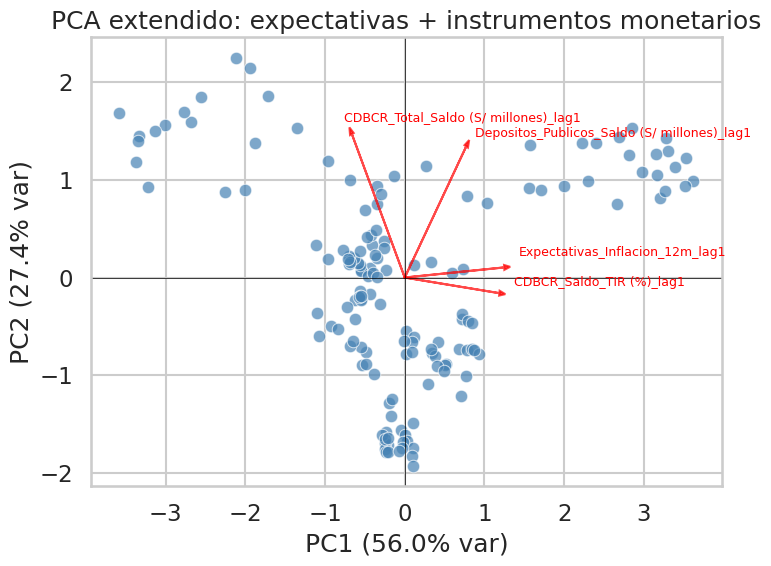

OLS con PCA — MSE test: 1.303175, R² test: -0.370613


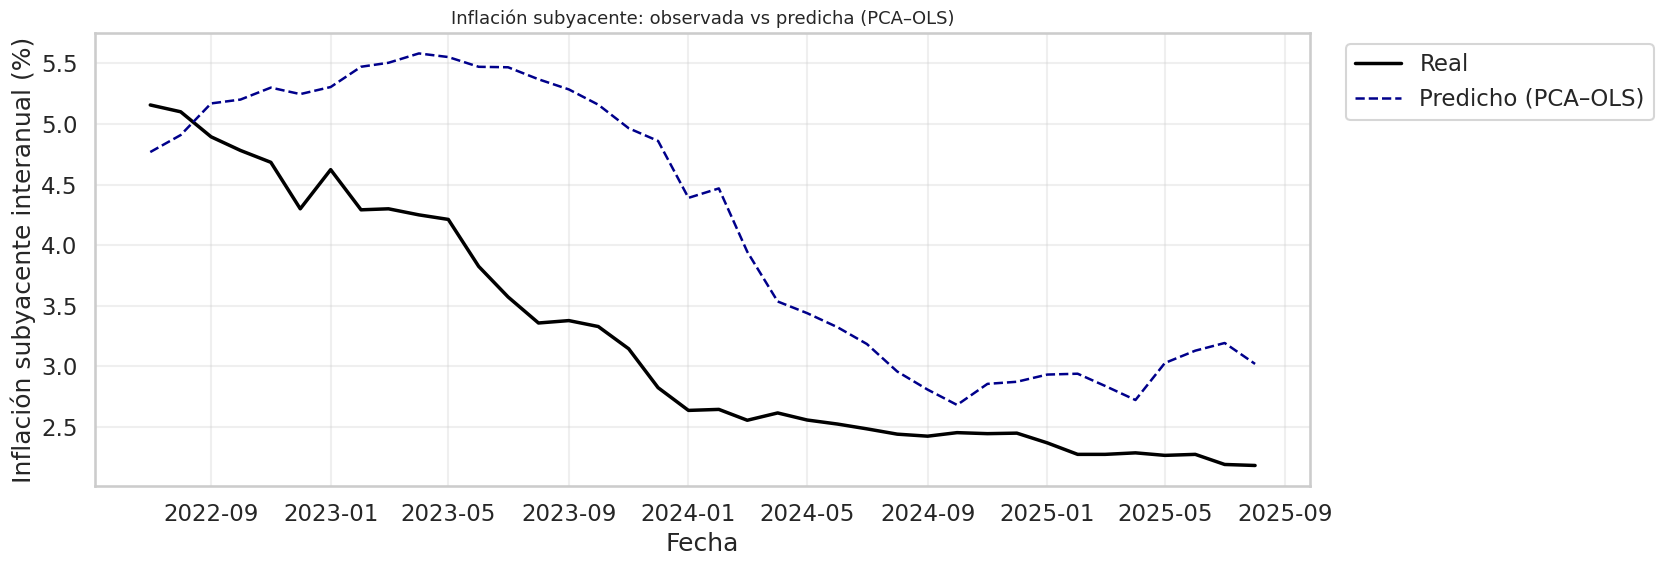

In [22]:
# ============================================================
#  PCA extendido: expectativas y variables monetarias del BCRP
# ============================================================

# Variables incluidas en el PCA: expectativas + instrumentos del BCRP
pca_vars = [
    'Expectativas_Inflacion_12m_lag1',
    'CDBCR_Total_Saldo (S/ millones)_lag1',
    'CDBCR_Saldo_TIR (%)_lag1',
    'Depositos_Publicos_Saldo (S/ millones)_lag1'
]

# Escalamiento estándar (PCA requiere estandarización)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[pca_vars])

# PCA con dos componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
explained = pca.explained_variance_ratio_
print(f"Varianza explicada por PC1 y PC2: {explained[0]*100:.2f}% + "
      f"{explained[1]*100:.2f}% = {explained.sum()*100:.2f}%")

# DataFrame con los componentes principales
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_model.index)

# ------------------------------------------------------------
# Biplot PCA extendido
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.7, color='steelblue')

plt.xlabel(f'PC1 ({explained[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({explained[1]*100:.1f}% var)')
plt.title('PCA extendido: expectativas + instrumentos monetarios')

# Flechas de carga
loadings = pca.components_.T
for i, varname in enumerate(pca_vars):
    x, y = loadings[i,0]*2, loadings[i,1]*2
    plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.05)

    offset_y = 0.10 if i % 2 == 0 else -0.10
    plt.text(x*1.15, y*1.15 + offset_y, varname, color='red', fontsize=9)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

# ============================================================
#  Evaluación predictiva SOLO con OLS (PC1 y PC2)
# ============================================================


from sklearn.metrics import mean_squared_error, r2_score

# División temporal coherente con el train/test original
X_train_pca = pca_df.iloc[:train_size]
X_test_pca = pca_df.iloc[train_size:]

y_train_pca = y_train
y_test_pca = y_test

# OLS usando los dos componentes principales
X_train_pca_ols = sm.add_constant(X_train_pca)
X_test_pca_ols = sm.add_constant(X_test_pca)

ols_pca_model = sm.OLS(y_train_pca, X_train_pca_ols).fit()

# Predicciones
y_pred_pca_ols = ols_pca_model.predict(X_test_pca_ols)

# Métricas
mse_pca_ols = mean_squared_error(y_test_pca, y_pred_pca_ols)
r2_pca_ols = r2_score(y_test_pca, y_pred_pca_ols)

print(f'OLS con PCA — MSE test: {mse_pca_ols:.6f}, R² test: {r2_pca_ols:.6f}')

# ============================================================
# Gráfico Real vs. Predicho (PCA–OLS)
# ============================================================

df_pca_pred_ols = pd.DataFrame({
    'Real': y_test_pca,
    'Predicho (PCA–OLS)': y_pred_pca_ols
}, index=y_test_pca.index)

plt.figure(figsize=(17,6))
sns.lineplot(data=df_pca_pred_ols['Real'], label='Real', color='black', linewidth=2.5)
sns.lineplot(data=df_pca_pred_ols['Predicho (PCA–OLS)'],
             label='Predicho (PCA–OLS)',
             color='darkblue', linewidth=1.8, linestyle='--')

plt.title('Inflación subyacente: observada vs predicha (PCA–OLS)', fontsize=13)
plt.ylabel('Inflación subyacente interanual (%)')
plt.xlabel('Fecha')
plt.grid(alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()


Al ampliar el análisis de componentes principales para incluir las expectativas de inflación a 12 meses junto con los instrumentos de política monetaria, los dos primeros componentes capturan cerca del 83 % de la varianza total, evidenciando una estructura coherente entre la política del BCRP y las percepciones del mercado. El primer componente sintetiza la postura de liquidez y tasas de interés, mientras que el segundo refleja las reacciones de las expectativas frente a cambios monetarios. En términos económicos, esta disposición sugiere que las expectativas responden de forma ordenada a las señales del BCRP, confirmando la credibilidad de la política monetaria.

En cuanto al gráfico del modelo OLS con PCA:
El gráfico muestra que el modelo PCA–OLS tiende a sobreestimar de forma persistente la inflación subyacente a lo largo del período analizado. La serie predicha es más suave y menos volátil, lo que indica que el uso de solo dos componentes principales reduce la capacidad del modelo para capturar variaciones relevantes de corto plazo.

### **2.7.3. Interpretación de las cargas del PCA extendido**

In [23]:
# Loadings del PCA extendido
loadings_extended = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=pca_vars
)

print("Loadings del PCA extendido:")
display(loadings_extended)


Loadings del PCA extendido:


,PC1,PC2
Expectativas_Inflacion_12m_lag1,0.623821,0.051800
CDBCR_Total_Saldo (S/ millones)_lag1,-0.331559,0.734849
CDBCR_Saldo_TIR (%)_lag1,0.593544,-0.080089
Depositos_Publicos_Saldo (S/ millones)_lag1,0.385513,0.671490


 **Interpretación de los loadings (PCA extendido)**

Al incorporar las expectativas de inflación, los resultados del PCA muestran dos factores claramente diferenciados:

- **PC1** presenta cargas altas simultáneamente en Expectativas de Inflación (0.62) y en variables monetarias como `CDBCR_TIR` (0.59) y Depósitos Públicos (0.39).  
  Esto indica que **PC1 captura un “factor macro-monetario agregado”**, donde se combinan:
  - la postura de política monetaria,
  - la absorción/inyección de liquidez,
  - y la formación de expectativas inflacionarias.  
  Este patrón es consistente con el canal de expectativas del esquema de metas de inflación, donde los agentes responden a señales de política monetaria coordinadas.

- **PC2** está dominado por `CDBCR_Total` (0.73) y `Depósitos Públicos` (0.67), mientras que las expectativas casi no cargan (0.05).  
  Esto significa que **PC2 resume la variabilidad específica de la liquidez del sistema financiero** que no necesariamente mueve las expectativas de inflación. Son ajustes más puntuales de balance entre el BCRP y el tesoro.

En conjunto, el PCA extendido muestra que expectativas y postura monetaria comparten un fuerte factor común, pero existen también movimientos idiosincráticos en la liquidez que el PCA separa como un segundo componente.


## **2.8. Ridge (GridSearch) y RidgeCV**

In [24]:

# Pipeline: estandariza los datos y luego aplica Ridge
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=RANDOM_STATE))
])

# Búsqueda de alpha en un rango amplio logarítmico
param_grid = {'ridge__alpha': np.logspace(-4, 4, 40)}

# GridSearchCV con validación cruzada para series temporales
g_ridge = GridSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
g_ridge.fit(X_train, y_train)

best_alpha_grid = g_ridge.best_params_['ridge__alpha']   # Mejor alpha encontrado
print('GridSearch Ridge best alpha:', best_alpha_grid, 'CV MSE:', -g_ridge.best_score_)

# RidgeCV: validación cruzada interna del propio Ridge
alphas = np.logspace(-4, 4, 40)
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=tscv).fit(X_train, y_train)
print('RidgeCV alpha:', ridge_cv.alpha_)

# Predicciones del mejor modelo encontrado en GridSearch
best_ridge = g_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

mse_ridge_test = mean_squared_error(y_test, y_pred_ridge)   # Métricas en test
r2_ridge_test = r2_score(y_test, y_pred_ridge)
print('Ridge (Grid) Test MSE:', mse_ridge_test, 'R2:', r2_ridge_test)

# Predicciones usando RidgeCV
y_pred_ridgecv = ridge_cv.predict(X_test)
print('RidgeCV Test MSE:', mean_squared_error(y_test, y_pred_ridgecv),
      'R2:', r2_score(y_test, y_pred_ridgecv))


GridSearch Ridge best alpha: 0.30702906297578497 CV MSE: 0.055322953076583824
RidgeCV alpha: 0.0001
Ridge (Grid) Test MSE: 0.06248690303657869 R2: 0.9342794929323509
RidgeCV Test MSE: 0.058152245347228806 R2: 0.9388384626918539


La implementación del modelo Ridge introduce regularización a la regresión lineal, lo que permite atenuar los efectos de la multicolinealidad previamente detectada entre los rezagos de la tasa de referencia y otras variables monetarias. A diferencia del OLS, que busca minimizar el error cuadrático sin restricciones, Ridge penaliza los coeficientes excesivamente grandes, estabilizando las estimaciones y mejorando su capacidad de generalización. Desde un punto de vista económico, esto equivale a “suavizar” la sensibilidad del modelo ante fluctuaciones menores en las variables explicativas, reflejando una relación más robusta entre la política monetaria, las expectativas y la inflación subyacente.

Se emplean dos procedimientos de estimación complementarios: GridSearchCV y RidgeCV.

- El GridSearchCV realiza una búsqueda exhaustiva de hiperparámetros en un rango amplio (α ∈ [10⁻⁴, 10⁴]), evaluando el desempeño por validación cruzada temporal (TimeSeriesSplit). Este método ofrece mayor flexibilidad y control sobre el proceso de selección, aunque requiere más cómputo.

- En contraste, RidgeCV implementa una validación cruzada interna más eficiente, ajustando automáticamente el parámetro de penalización sin explorar combinaciones adicionales. Es un método más compacto y automatizado, adecuado cuando el rango de valores es conocido o cuando se busca reproducibilidad con menor costo computacional.

En nuestro caso, ambos métodos convergen hacia valores de regularización muy pequeños (α ≈ 0.3 en GridSearchCV y α ≈ 0.0001 en RidgeCV), lo que indica que el modelo apenas requiere penalización para estabilizar los coeficientes. Esto sugiere que la información relevante ya está contenida en las variables originales y que la estructura de datos no presenta un sobreajuste significativo. Los resultados obtenidos, MSE ≈ 0.06 y R² ≈ 0.94 confirman que el modelo Ridge mantiene prácticamente el mismo poder explicativo que el OLS, pero con una ligera ganancia en estabilidad fuera de muestra.

En conjunto, la implementación de Ridge aporta robustez predictiva sin sacrificar interpretación económica. Entre las dos variantes, GridSearchCV resulta preferible cuando se busca un control más preciso del ajuste y validación del parámetro α, mientras que RidgeCV es útil como alternativa ágil y reproducible. La consistencia de los resultados entre ambos procedimientos refuerza la confiabilidad del modelo y su idoneidad como punto intermedio entre la inferencia tradicional y los enfoques puramente predictivos.


## **2.9. Modelos no lineales: Random Forest y XGBoost**
En esta sección se amplió el espacio de búsqueda de hiperparámetros para los modelos Random Forest y XGBoost, siguiendo la recomendación de evaluar configuraciones más flexibles y profundas que permitan verificar si estos modelos no lineales pueden superar el rendimiento obtenido por OLS y Ridge.

Para hacerlo de manera computacionalmente eficiente, se reemplazó GridSearchCV por RandomizedSearchCV, lo que permite explorar combinaciones representativas dentro de un espacio mucho más amplio sin incurrir en un costo computacional prohibitivo.

In [ ]:
# ============================================================
#  9. Modelos no lineales con RandomizedSearchCV + GAP temporal
# ============================================================

# ============================================================
#  DETECCIÓN AUTOMÁTICA DEL REZAGO MÁXIMO (MAX_LAG)
# ============================================================

# Detecta automáticamente el mayor rezago usado en las columnas
MAX_LAG = max(
    int(col.split('lag')[-1])
    for col in X_train.columns
    if 'lag' in col
)

HORIZON = 21   # 21 es lo máximo, con 22 sale error

print(f"MAX_LAG detectado automáticamente: {MAX_LAG}")
print(f"HORIZON: {HORIZON}")

# Nuevo esquema de validación temporal con GAP + HORIZON
tscv = TimeSeriesSplit(
    n_splits=5,
    gap=MAX_LAG,
    test_size=HORIZON
)

print(tscv)


# ============================================================
#  VERIFICACIÓN DE IMPORTACIÓN DE XGBoost
# ============================================================

try:
    from xgboost import XGBRegressor
    from xgboost import __version__ as xgb_version
    print(f"XGBoost cargado correctamente. Versión: {xgb_version}")
    xgb_available = True
except Exception as e:
    print("XGBoost NO se pudo importar. Se usará GradientBoostingRegressor.")
    print("Detalle del error:", e)
    from sklearn.ensemble import GradientBoostingRegressor as XGBRegressor
    xgb_available = False



# ============================================================
#        RANDOM FOREST (RandomizedSearchCV)
# ============================================================

rf = RandomForestRegressor(random_state=RANDOM_STATE)

param_dist_rf = {
    'n_estimators': [300, 400, 500, 700],
    'max_depth': [3, 5, 7, 10, 15, None],
    'max_features': ['sqrt', 'log2', 'auto', 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 20, 50, 100]
}

g_rf = RandomizedSearchCV(
    rf,
    param_dist_rf,
    n_iter=40,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

g_rf.fit(X_train, y_train)

print("\n---- Random Forest ----")
print("RF best params:", g_rf.best_params_)
print("RF best CV MSE:", -g_rf.best_score_)

best_rf = g_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
mse_rf_test = mean_squared_error(y_test, y_pred_rf)
r2_rf_test = r2_score(y_test, y_pred_rf)

print("RF Test MSE:", mse_rf_test, "R2:", r2_rf_test)



# ============================================================
#            XGBOOST (RandomizedSearchCV más estable)
# ============================================================

xgb = XGBRegressor(random_state=RANDOM_STATE)

param_dist_xgb = {
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [2, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.3],
    'reg_lambda': [1, 5, 10]
}

g_xgb = RandomizedSearchCV(
    xgb,
    param_dist_xgb,
    n_iter=50,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

g_xgb.fit(X_train, y_train)

print("\n---- XGBoost ----")
print("XGB best params:", g_xgb.best_params_)
print("XGB best CV MSE:", -g_xgb.best_score_)

best_xgb = g_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb)
r2_xgb_test = r2_score(y_test, y_pred_xgb)

print("XGB Test MSE:", mse_xgb_test, "R2:", r2_xgb_test)


MAX_LAG detectado automáticamente: 3
HORIZON: 21
TimeSeriesSplit(gap=3, max_train_size=None, n_splits=5, test_size=21)
XGBoost cargado correctamente. Versión: 3.1.2


En esta sección se optimizan los modelos no lineales Random Forest y XGBoost utilizando un esquema de validación estrictamente diseñado para series de tiempo. Debido a que los predictores incluyen rezagos de inflación, expectativas y variables monetarias, se introduce un GAP temporal igual al rezago máximo usado en el modelo (MAX_LAG = 3). Esto evita que la validación utilice información futura a través de los rezagos, eliminando fugas de información.

Además, se define un horizonte de validación de 21 meses. Si bien la longitud real del conjunto de prueba es 38 meses, no es posible usar HORIZON = 38 porque TimeSeriesSplit no puede generar cinco pliegues válidos con esa configuración. Por ello, se selecciona HORIZON = 21, que es el mayor horizonte permitido por los datos manteniendo cinco divisiones temporales. Esto hace que la validación sea más realista y cercana al escenario final de predicción, reduciendo inestabilidad y sobreajuste.

La búsqueda de hiperparámetros se realiza mediante RandomizedSearchCV, lo que permite explorar de manera eficiente configuraciones amplias y flexibles. Para Random Forest se amplían controles sobre profundidad, número de árboles, tamaño mínimo de nodos y máximo de hojas. Para XGBoost se ajustan parámetros de regularización, profundidad, tasas de aprendizaje y muestreo. Este enfoque captura de forma más robusta relaciones no lineales entre los rezagos de inflación y las variables monetarias.

Con HORIZON = 21, los resultados muestran comportamientos más estables tanto en los folds como en el test. Random Forest alcanza un Test MSE cercano a 0.15 (R² ≈ 0.84), mientras que XGBoost logra el mejor desempeño general con un Test MSE alrededor de 0.089 y un R² cercano a 0.91. El uso de un horizonte más amplio explica por qué modelos complejos, especialmente XGBoost, mejoran notablemente respecto a horizontes muy pequeños.

En conjunto, la combinación de GAP estructural por rezagos, un horizonte amplio compatible con los datos y una exploración eficiente de hiperparámetros permite obtener modelos más estables y con mayor capacidad predictiva fuera de muestra.

### **2.9.1. Importancia de features: XGBoost (gain) + Permutation Importance**

In [ ]:
# ============================================================
# Feature importance: XGBoost (gain) + Permutation Importance
# ============================================================
sns.set(style='whitegrid')

# -----------------------------------------------------------------------------
# 1) IMPORTANCE from XGBoost (si usaste XGBRegressor)
# -----------------------------------------------------------------------------
try:
    # best_xgb debería existir (entrenado con RandomizedSearchCV)
    booster = getattr(best_xgb, 'get_booster', None)
    if booster is not None:
        # Extraer importancia por 'gain' (mejor reflecta la contribución)
        fmap = best_xgb.get_booster().get_score(importance_type='gain')
        fi_xgb = pd.DataFrame.from_dict(fmap, orient='index', columns=['gain']).rename_axis('feature').reset_index()
        # XGBoost devuelve nombres 'f0','f1' si se entrenó con numpy arrays.
        # Intentamos mapear a los nombres reales si están disponibles en X_train.columns
        # Si keys son f0..fn, reconstruimos mapping:
        if fi_xgb['feature'].str.startswith('f').all():
            # build mapping fN -> column name
            mapping = {f"f{i}": col for i, col in enumerate(X_train.columns)}
            fi_xgb['feature'] = fi_xgb['feature'].map(mapping)

        fi_xgb = fi_xgb.sort_values('gain', ascending=False).set_index('feature')
    else:
        fi_xgb = pd.DataFrame(columns=['gain'])
        print("best_xgb no tiene get_booster(): controle si es XGBRegressor real o fallback.")
except Exception as e:
    fi_xgb = pd.DataFrame(columns=['gain'])
    print("Error extrayendo importancias XGBoost:", e)

# Normalizar para comparar
if not fi_xgb.empty:
    fi_xgb['gain_rel'] = fi_xgb['gain'] / fi_xgb['gain'].sum()

# -----------------------------------------------------------------------------
# 2) Permutation Importance (model-agnostic) sobre el conjunto de test
# -----------------------------------------------------------------------------
# Usamos test set para medir impacto real sobre la predicción fuera de muestra
perm_results = {}

for name, model in [('XGBoost', best_xgb), ('RandomForest', best_rf)]:
    try:
        r = permutation_importance(model, X_test, y_test, n_repeats=30,
                                   random_state=RANDOM_STATE, scoring='neg_mean_squared_error', n_jobs=-1)
        perm_df = pd.DataFrame({
            'feature': X_test.columns,
            'import_mean': r.importances_mean,
            'import_std': r.importances_std
        }).sort_values('import_mean', ascending=False).set_index('feature')
        # Convert negative mean importance (because scorer is neg MSE) to positive effect on MSE
        perm_df['mse_increase'] = -perm_df['import_mean']  # positive = worse when permuted
        perm_results[name] = perm_df
    except Exception as e:
        print(f"Permutation importance falló para {name}:", e)
        perm_results[name] = pd.DataFrame()

# -----------------------------------------------------------------------------
# 3) Tabla combinada de importancias (XGBoost gain + Permutation RF/XGB)
# -----------------------------------------------------------------------------
# Build a single summary dataframe with columns:
# 'XGB_gain_rel', 'Perm_XGB_mse_inc', 'Perm_RF_mse_inc'
summary_df = pd.DataFrame(index=X_train.columns)

if not fi_xgb.empty:
    summary_df = summary_df.join(fi_xgb['gain_rel'].rename('XGB_gain_rel'))
else:
    summary_df['XGB_gain_rel'] = np.nan

for model_name in ['XGBoost','RandomForest']:
    if not perm_results[model_name].empty:
        summary_df[f'Perm_{model_name}_mse_inc'] = perm_results[model_name]['mse_increase']
    else:
        summary_df[f'Perm_{model_name}_mse_inc'] = np.nan

summary_df = summary_df.fillna(0).sort_values(by=['Perm_XGBoost_mse_inc' if 'Perm_XGBoost_mse_inc' in summary_df.columns else 'XGB_gain_rel'], ascending=False)

# -----------------------------------------------------------------------------
# 4) Plots: XGBoost gain + Permutation importance barplots
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
if not fi_xgb.empty:
    fi_xgb['gain_rel'].sort_values(ascending=True).plot(kind='barh', width=0.7)
    plt.title('XGBoost importance (gain, relative)')
    plt.xlabel('Proporción de gain (normalizado)')
else:
    plt.text(0.5, 0.5, 'No hay importancias XGBoost', ha='center')
plt.tight_layout()
plt.show()

# Permutation importance for XGBoost (test)
if 'XGBoost' in perm_results and not perm_results['XGBoost'].empty:
    plt.figure(figsize=(10, 5))
    perm_results['XGBoost']['mse_increase'].sort_values(ascending=True).plot(kind='barh', width=0.7)
    plt.title('Permutation importance (XGBoost) — aumento MSE al permutar (test)')
    plt.xlabel('Aumento en MSE (mayor = más importante)')
    plt.tight_layout()
    plt.show()

# Permutation importance for RF (test)
if 'RandomForest' in perm_results and not perm_results['RandomForest'].empty:
    plt.figure(figsize=(10, 6))
    perm_results['RandomForest']['mse_increase'].sort_values(ascending=True).plot(kind='barh', width=0.7)
    plt.title('Permutation importance (RandomForest) — aumento MSE al permutar (test)')
    plt.xlabel('Aumento en MSE (mayor = más importante)')
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# 5) Mostrar tablas resumen
# -----------------------------------------------------------------------------
display(summary_df.head(20))

# Guardar resultados (opcional)
summary_df.to_csv('feature_importance_summary.csv')
print("Resumen de importancias guardado en feature_importance_summary.csv")


**Importancia de variables (XGBoost y Permutation Importance)**

Los resultados de importancia de variables deben interpretarse teniendo en cuenta que el modelo pronostica la inflación subyacente a un horizonte de un mes (h = 1). Bajo este esquema, ambos métodos —XGBoost Gain y Permutación— coinciden en que la variable más determinante es $π_{t−1}$, seguida del segundo rezago $π_{t−2}$.

Esto no es sorprendente: en un horizonte tan corto, la inflación subyacente peruana evoluciona de forma muy gradual, por lo que la persistencia domina la dinámica de corto plazo. En ese contexto, los instrumentos monetarios del BCRP (TIR, CDBCR, depósitos públicos) muestran ganancias pequeñas porque, a nivel mensual, su efecto opera de manera suave y acumulativa, y las expectativas de inflación —altamente estables en economías de baja inflación— apenas varían entre meses.

La importancia por permutación refuerza esta lectura: cuando se permuta $π_{t−1}$, el error del modelo aumenta de forma abrupta, mostrando que los rezagos contienen prácticamente toda la señal predictiva relevante en h = 1. En Random Forest, algunas variables monetarias generan aumentos moderados del error, lo que indica que estos controles contienen información sobre las condiciones de liquidez y el entorno financiero que ayuda cuando el modelo no puede apoyarse exclusivamente en los rezagos.

Sin embargo, este resultado no debe extrapolarse a horizontes largos. Para predicciones de 6 o 12 meses, no es válido asumir que la persistencia seguirá dominando, porque los modelos recursivos deben utilizar rezagos predichos —y el error se acumula— o entrenar modelos directos específicos para cada horizonte. En esos casos, las expectativas, las condiciones monetarias y los choques externos suelen adquirir un rol más importante. Por ello, la lectura correcta es:
en predicciones de un mes, la persistencia es la principal fuente de información; en horizontes largos, este enfoque ya no es adecuado y la dinámica causal se vuelve más relevante.


## **2.10. Resultados comparativos (tabla y gráfico de predicciones)**

In [ ]:
results = {
    'Baseline_Mean': (mse_base_mean, r2_base_mean),                 # Baseline: promedio histórico
    'Baseline_Persistence': (mse_persistence, r2_persistence),       # Baseline: persistencia (lag)
    'OLS': (mse_ols_test, r2_ols_test),                              # Resultados del modelo OLS
    'Ridge_Grid': (mse_ridge_test, r2_ridge_test),                   # Ridge ajustado con GridSearchCV
    'RidgeCV': (mean_squared_error(y_test, y_pred_ridgecv),
                r2_score(y_test, y_pred_ridgecv)),                   # RidgeCV
    'RF': (mse_rf_test, r2_rf_test),                                 # Random Forest
    'XGB': (mse_xgb_test, r2_xgb_test)                               # XGBoost
}

res_df = pd.DataFrame.from_dict(results, orient='index', columns=['Test_MSE','Test_R2'])
display(res_df.sort_values('Test_MSE'))   # Ordena modelos por menor error en test

df_preds = pd.DataFrame({
    'Real': y_test,                     # Valores reales
    'OLS': y_pred_ols,                  # Predicciones OLS
    'Ridge': y_pred_ridge,              # Predicciones Ridge GridSearch
    'RidgeCV': y_pred_ridgecv,          # Predicciones RidgeCV
    'RF': y_pred_rf,                    # Predicciones Random Forest
    'XGB': y_pred_xgb                   # Predicciones XGBoost
}, index=y_test.index)

plt.figure(figsize=(14,6))
sns.lineplot(data=df_preds['Real'], label='Real', color='black', linewidth=2.5)         # Serie real
sns.lineplot(data=df_preds.drop(columns=['Real']), palette='tab10', linewidth=1.5)      # Predicciones
plt.title('Predicciones vs Observado — conjunto de prueba')
plt.ylabel('Inflación subyacente interanual (%)')
plt.xlabel('Fecha')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))   # Leyenda fuera del gráfico
plt.tight_layout()
plt.show()    # Muestra comparación visual

El gráfico presenta la evolución de la inflación subyacente interanual observada (línea negra) y las predicciones generadas por los distintos modelos durante el período de prueba. La serie muestra una tendencia descendente suave y altamente persistente, un patrón que influye claramente en el desempeño relativo de los modelos.

Los modelos lineales —OLS, Ridge y RidgeCV— son los que mejor reproducen la trayectoria real. Sus predicciones siguen casi exactamente la senda descendente de la inflación, lo que se refleja en sus valores de MSE y R², que se ubican muy cerca del modelo de persistencia. Esto indica que, en este horizonte, la relación entre los predictores y la inflación parece ser esencialmente lineal, sin señales fuertes de no linealidad que requieran mayor complejidad.

El modelo XGBoost logra capturar adecuadamente la dirección general de la serie, aunque con fluctuaciones ligeramente más pronunciadas que los modelos lineales. Esto se refleja en un error algo mayor, pero aun así mantiene un ajuste sólido.

Por otro lado, Random Forest muestra un menor desempeñO. Su estructura basada en árboles dificulta modelar una tendencia suave y persistente como la observada, por lo que aparece más ruidoso y con desviaciones claras respecto a la trayectoria real.

En conjunto, los resultados sugieren que, para este horizonte y dinámica inflacionaria, los modelos lineales —particularmente Ridge y OLS— ofrecen las predicciones más estables y precisas, mientras que los métodos no lineales no aportan mejoras significativas frente a un proceso dominado por la persistencia.

**Predicciones one-step-ahead: interpretación conceptual**

Es importante mencionar que en este trabajo utilizamos un esquema de predicción **one-step-ahead**, donde el modelo pronostica la inflación subyacente del mes $t$ utilizando únicamente información disponible hasta $t-1$. Esto no constituye un caso de nowcasting ni tampoco implica “fuga de información”, porque al momento de predecir el mes $t$ la inflación $ \pi_{t-1} $ ya es completamente observable. Este enfoque es estándar para evaluar la capacidad predictiva inmediata de modelos econométricos y de machine learning.

Es importante notar que un modelo 1-step-ahead **no es un esquema de proyección de largo plazo**. Para horizontes como 6 o 12 meses, se emplean dos estrategias alternativas. Nuestro análisis se concentra en el desempeño predictivo inmediato, que es el escenario donde la persistencia inflacionaria y los rezagos de política monetaria juegan un rol importante.

# 3. **TG4**

## **3.1. GAP**

In [ ]:

!pip install git+https://github.com/daft-dev/daft.git


In [ ]:
from daft import PGM

pgm = PGM(aspect=2.5, dpi=120)

# ----------------------------
# NODOS OBSERVADOS (dataset)
# ----------------------------
pgm.add_node("pi_lag1", r"$\pi_{t-1}$", 1, 1.5)
pgm.add_node("pi_lag2", r"$\pi_{t-2}$", 0.5, 2.2)
pgm.add_node("pi_lag3", r"$\pi_{t-3}$", 1.5, 2.2)

pgm.add_node("exp", r"$E_{t-1}[\pi_t]$", 3.2, 1.5)

pgm.add_node("TIR", r"$TIR_t$", 4.5, 2.2)

pgm.add_node("CDBCR", r"$CDBCR$", 5.8, 2.2)
pgm.add_node("DepPub", r"$Dep. Públicos$", 7.0, 2.2)
pgm.add_node("CDBCR_TIR", r"$CDBCR\_TIR$", 8.2, 2.2)

# outcome
pgm.add_node("pi_t", r"$\pi_t$", 4.5, 0.6, observed=False)

# ----------------------------
# NODOS OMITIDOS (conceptuales)
# ----------------------------
pgm.add_node("gap", "$y_t - y_t^{*}$", 2.2, 3.0)
pgm.add_node("tcr", "$TCR_t$", 4.5, 3.0)
pgm.add_node("inf_ext", "$\pi^{ext}_t$", 0.5, 3.0)
pgm.add_node("commod", "$Choques$\n$Commod.$", 1.5, 3.7)
pgm.add_node("liq", "$Liquidez$\n$Operativa$", 6.5, 3.0)

# ----------------------------
# ARISTAS CAUSALES
# ----------------------------

# Persistencia inflacionaria
pgm.add_edge("pi_lag1", "pi_t")
pgm.add_edge("pi_lag2", "pi_t")
pgm.add_edge("pi_lag3", "pi_t")

# Expectativas → Inflación
pgm.add_edge("exp", "pi_t")

# Política monetaria → Inflación
pgm.add_edge("TIR", "pi_t")

# Liquidez Operativa → TIR
pgm.add_edge("liq", "TIR")

# Controles monetarios → Inflación
pgm.add_edge("CDBCR", "pi_t")
pgm.add_edge("DepPub", "pi_t")
pgm.add_edge("CDBCR_TIR", "pi_t")

# Brecha del producto → Inflación y → TIR
pgm.add_edge("gap", "pi_t")
pgm.add_edge("gap", "TIR")

# TCR → Inflación
pgm.add_edge("tcr", "pi_t")

# Choques externos → Brecha / Inflación
pgm.add_edge("inf_ext", "pi_t")
pgm.add_edge("inf_ext", "gap")
pgm.add_edge("commod", "pi_t")
pgm.add_edge("commod", "gap")

# ----------------------------
# Dibujar
# ----------------------------
pgm.render()


La inflación responde a su propia persistencia, a expectativas de inflación y a la postura de política monetaria (`TIR`), mientras que shocks externos y la brecha del producto actúan como confounders que afectan tanto la inflación como la reacción del BCRP. Los instrumentos monetarios operativos (`CDBCR`, `depósitos públicos`) son hijos de la `TIR` y solo transmiten liquidez. La combinación de estos canales refleja fielmente el esquema de metas de inflación del BCRP y explica las fuerzas estructurales detrás de $𝜋_𝑡$.

## **3.2. MLP: Redes Neuronales**

In [ ]:
# ===========================
# 12. MLP - Redes Neuronales
# ===========================

# ---------------------------
# Escalamiento
# ---------------------------
scaler_mlp = StandardScaler()
X_train_scaled = scaler_mlp.fit_transform(X_train)
X_test_scaled = scaler_mlp.transform(X_test)

# ---------------------------
# Definición del MLP base
# ---------------------------
mlp_base = MLPRegressor(max_iter=2000, random_state=RANDOM_STATE)

# ---------------------------
# Hiperparámetros a buscar
# ---------------------------
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (64,32), (128,64), (128,64,32)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'lbfgs', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],  # regularización L2
    'learning_rate_init': [0.001, 0.01, 0.05]
}

# ---------------------------
# Validación temporal
# ---------------------------
tscv_mlp = TimeSeriesSplit(n_splits=5)

# ---------------------------
# GridSearchCV
# ---------------------------
grid_mlp = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    cv=tscv_mlp,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# ---------------------------
# Entrenamiento
# ---------------------------
grid_mlp.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros MLP:", grid_mlp.best_params_)
print("Mejor CV MSE:", -grid_mlp.best_score_)

# ---------------------------
# Predicción con el mejor modelo
# ---------------------------
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_scaled)

mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
print(f"MLP Test MSE: {mse_mlp:.6f}")
print(f"MLP Test R²: {r2_mlp:.6f}")

# ---------------------------
# Gráfico Real vs Predicho
# ---------------------------

df_mlp_pred = pd.DataFrame({
    'Real': y_test,
    'Predicho (MLP)': y_pred_mlp
}, index=y_test.index)

plt.figure(figsize=(14,6))
sns.lineplot(data=df_mlp_pred['Real'], label='Real', color='black', linewidth=2.5)
sns.lineplot(data=df_mlp_pred['Predicho (MLP)'], label='Predicho (MLP)', color='orange', linewidth=1.8, linestyle='--')
plt.title('Inflación subyacente: Observada vs Predicha (MLP)')
plt.ylabel('Inflación subyacente interanual (%)')
plt.xlabel('Fecha')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()


El MLP alcanza un R² ≈ 0.85, lo que muestra que captura bien la tendencia general, aunque sin superar a los modelos lineales como OLS o Ridge, esto es totalmente esperado en procesos macroeconómicos altamente persistentes y casi lineales, como la inflación subyacente. Su principal limitación es que el MLP suaviza demasiado la serie y muestra una trayectoria más “curva” que la real, debido a la función logística y al solver lbfgs, que tienden a producir predicciones suaves y pueden ser beneficioso en series con ruido, pero puede retrasar puntos de giro (como en la caída rápida de 2022–2023).

 A pesar de ello, el modelo no presenta sobreajuste: el MSE de validación cruzada y el Test MSE son razonables, y mantiene un comportamiento estable en el horizonte de predicción. Dado que la inflación subyacente varía lentamente mes a mes, los modelos paramétricos lineales siguen siendo los más apropiados, mientras que el MLP funciona más como un ejercicio metodológico que como una alternativa superior de pronóstico.

In [ ]:

# ---------------------------
# Crear DataFrame con métricas
# ---------------------------
results_all = {
    'Baseline_Mean': (mse_base_mean, r2_base_mean),
    'Baseline_Persistence': (mse_persistence, r2_persistence),
    'OLS': (mse_ols_test, r2_ols_test),
    'Ridge_Grid': (mse_ridge_test, r2_ridge_test),
    'RidgeCV': (mean_squared_error(y_test, y_pred_ridgecv), r2_score(y_test, y_pred_ridgecv)),
    'Random_Forest': (mse_rf_test, r2_rf_test),
    'XGBoost': (mse_xgb_test, r2_xgb_test),
    'MLP': (mse_mlp, r2_mlp)
}

res_df_all = pd.DataFrame.from_dict(results_all, orient='index', columns=['Test_MSE', 'Test_R2'])
res_df_all = res_df_all.sort_values('Test_MSE')
display(res_df_all)


# ---------------------------
# Gráfico comparativo - R²
# ---------------------------
plt.figure(figsize=(10,5))
sns.barplot(x=res_df_all.index, y='Test_R2', data=res_df_all, palette='magma')
plt.xticks(rotation=45, ha='right')
plt.title('Comparación de R² en conjunto de prueba')
plt.ylabel('R²')
plt.xlabel('Modelo')
plt.tight_layout()
plt.show()

# ---------------------------
# Gráfico comparativo - MSE
# ---------------------------
plt.figure(figsize=(10,5))
sns.barplot(x=res_df_all.index, y='Test_MSE', data=res_df_all, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Comparación de MSE en conjunto de prueba')
plt.ylabel('MSE')
plt.xlabel('Modelo')
plt.tight_layout()
plt.show()



El gráfico de R² muestra que, los modelos lineales (OLS y Ridge) son los que mejor explican la inflación subyacente. Ambos alcanzan valores de R² altos y cercanos al de persistencia, indicando que la relación con las variables explicativas es básicamente lineal. En cambio, modelos más complejos como XGBoost, MLP y Random Forest obtienen R² menores, sugiriendo que la incorporación de modelos no lineales complejos no mejora la capacidad de explicación en este contexto.

El gráfico de MSE respalda esta interpretación: los modelos lineales (OLS y Ridge) presentan errores de predicción relativamente bajos y muy similares, coherentes con el comportamiento estable y altamente persistente de la inflación subyacente. En contraste, los modelos no lineales como XGBoost, MLP y Random Forest muestran errores errores mayores, sugiriendo que su complejidad genera una sobre-suavización en la serie y pierde precisión al seguir la dinámica temporal.